<a href="https://colab.research.google.com/github/YasminaNasser/Hate_Speech_Detection/blob/main/Deep_Learning_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hate Speech Detection using Deep Learning

**Ain Shams University - Faculty of Engineering**  
**CSE485 Deep Learning: Major Task**

---

## Project Overview

This project implements a Deep Learning model to detect hate speech in tweets using LSTM (Long Short-Term Memory) networks. The dataset contains tweets classified into three categories:

- **0 - Hate Speech**: Content explicitly targeting individuals or groups with harmful intent
- **1 - Offensive Language**: Content containing offensive language but not necessarily hate speech  
- **2 - Neither**: Neutral content without any offensive or hateful intent

## Objectives

1. Explore and visualize the dataset
2. Preprocess textual data (stopwords, punctuation removal, lemmatization)
3. Build and train an LSTM model
4. Evaluate model performance
5. Analyze results comprehensively

## 1. Import Required Libraries


In [1]:
# ============================================================
# 📦 INSTALL ALL REQUIRED PACKAGES
# ============================================================
# Run this cell FIRST if you're setting up for the first time!
# This installs all necessary packages for the entire notebook.

%pip install pandas numpy matplotlib seaborn -q
%pip install nltk tensorflow scikit-learn -q
%pip install imbalanced-learn wordcloud contractions -q

print("✅ All packages installed successfully!")
print("\n📋 Installed packages:")
print("  • pandas, numpy - Data manipulation")
print("  • matplotlib, seaborn - Visualization")
print("  • nltk - Natural Language Processing")
print("  • tensorflow - Deep Learning (LSTM model)")
print("  • scikit-learn - ML utilities & metrics")
print("  • imbalanced-learn - SMOTE for class balancing")
print("  • wordcloud - Word cloud visualizations")
print("  • contractions - Contraction expansion (200+ mappings)")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.1/345.1 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.3 MB/s eta 0:00:00
✅ All packages installed successfully!

📋 Installed packages:
  • pandas, numpy - Data manipulation
  • matplotlib, seaborn - Visualization
  • nltk - Natural Language Processing
  • tensorflow - Deep Learning (LSTM model)
  • scikit-learn - ML utilities & metrics
  • imbalanced-learn - SMOTE for class balancing
  • wordcloud - Word cloud visualizations
  • contractions - Contraction expansion (200+ mappings)


In [2]:
# Mount Google Drive (optional for saving outputs)
from google.colab import drive
drive.mount('/content/drive')

print("Setup complete!")

Mounted at /content/drive
Setup complete!


In [3]:
# Data manipulation and analysis
import pandas as pd
import numpy as np
import re
import string

# Google Drive download (Colab only)
!pip install gdown -q
import gdown

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Text preprocessing
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Deep Learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Embedding, Dropout, Bidirectional, SpatialDropout1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Machine Learning utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.utils import class_weight

# Handling imbalanced data
from imblearn.over_sampling import SMOTE

# Warnings
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")

# Download required NLTK data
print("Downloading NLTK data...")
nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("✓ All NLTK data downloaded!")

All libraries imported successfully!
TensorFlow version: 2.19.0
✓ All NLTK data downloaded!


## 2. Load and Explore Dataset


In [4]:

# Download from Google Drive
file_id = '1tn2X9JtOjqG7PKTZLUEy8sJS0r_WV7Qf'
url = f'https://drive.google.com/uc?id={file_id}'
gdown.download(url, 'hate_speech.csv', quiet=False)

# Load dataset
df = pd.read_csv('hate_speech.csv')
print("✓ Dataset loaded!")
print(f"Shape: {df.shape}")
print(df['class'].value_counts().sort_index())
df.head()

Downloading...
From: https://drive.google.com/uc?id=1tn2X9JtOjqG7PKTZLUEy8sJS0r_WV7Qf
To: /content/hate_speech.csv
100%|██████████| 2.21M/2.21M [00:00<00:00, 39.8MB/s]


✓ Dataset loaded!
Shape: (24783, 2)
class
0     1430
1    19190
2     4163
Name: count, dtype: int64


,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


In [5]:
# Basic dataset information
print("Dataset Information:")
print(df.info())
print("\n" + "="*50)
print("\nBasic Statistics:")
print(df.describe())
print("\n" + "="*50)
print("\nMissing Values:")
print(df.isnull().sum())
print("\n" + "="*50)
print("\nDuplicate Rows:")
print(f"Number of duplicate rows: {df.duplicated().sum()}")

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24783 entries, 0 to 24782
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   class   24783 non-null  int64 
 1   tweet   24783 non-null  object
dtypes: int64(1), object(1)
memory usage: 387.4+ KB
None


Basic Statistics:
              class
count  24783.000000
mean       1.110277
std        0.462089
min        0.000000
25%        1.000000
50%        1.000000
75%        1.000000
max        2.000000


Missing Values:
class    0
tweet    0
dtype: int64


Duplicate Rows:
Number of duplicate rows: 0


## 3. Data Visualization and Class Distribution

In [6]:
# Class distribution
class_counts = df['class'].value_counts().sort_index()
print("Class Distribution:")
print(class_counts)
print("\n" + "="*50)
print("\nClass Distribution (Percentage):")
print(df['class'].value_counts(normalize=True).sort_index() * 100)

# Create labels for classes
class_labels = {
    0: 'Hate Speech',
    1: 'Offensive Language',
    2: 'Neither'
}

Class Distribution:
class
0     1430
1    19190
2     4163
Name: count, dtype: int64


Class Distribution (Percentage):
class
0     5.770084
1    77.432111
2    16.797805
Name: proportion, dtype: float64


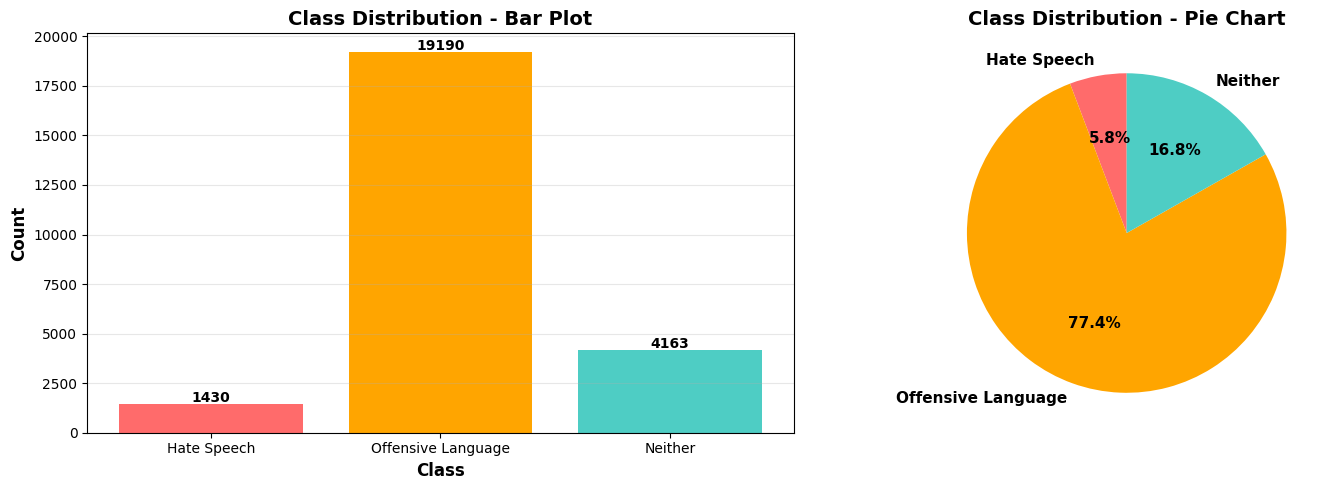

In [7]:
# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Bar plot
class_counts_labeled = class_counts.rename(class_labels)
axes[0].bar(class_counts_labeled.index, class_counts_labeled.values, color=['#FF6B6B', '#FFA500', '#4ECDC4'])
axes[0].set_xlabel('Class', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title('Class Distribution - Bar Plot', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, v in enumerate(class_counts_labeled.values):
    axes[0].text(i, v + 100, str(v), ha='center', fontweight='bold')

# Pie chart
colors = ['#FF6B6B', '#FFA500', '#4ECDC4']
axes[1].pie(class_counts.values, labels=[class_labels[i] for i in class_counts.index],
            autopct='%1.1f%%', colors=colors, startangle=90, textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[1].set_title('Class Distribution - Pie Chart', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

#### 📌 Key Findings: Class Distribution

**Critical Observations:**
1. **Severe Class Imbalance Detected:**
   - Offensive Language dominates with **77.4%** (19,190 tweets)
   - Neither class: **16.8%** (4,163 tweets)
   - Hate Speech is severely underrepresented: **5.8%** (1,430 tweets)

2. **Imbalance Ratio:** The largest class (Offensive) is **13.4x larger** than the smallest (Hate Speech)

**Implications for Model Training:**
- ⚠️ Standard accuracy metrics will be misleading (model could predict "Offensive" for everything and get 77% accuracy)
- ✅ **Solution:** We will use **class weights** to penalize misclassification of minority classes
- ✅ **Evaluation:** Focus on **F1-score per class** and **macro-averaged metrics** rather than accuracy alone

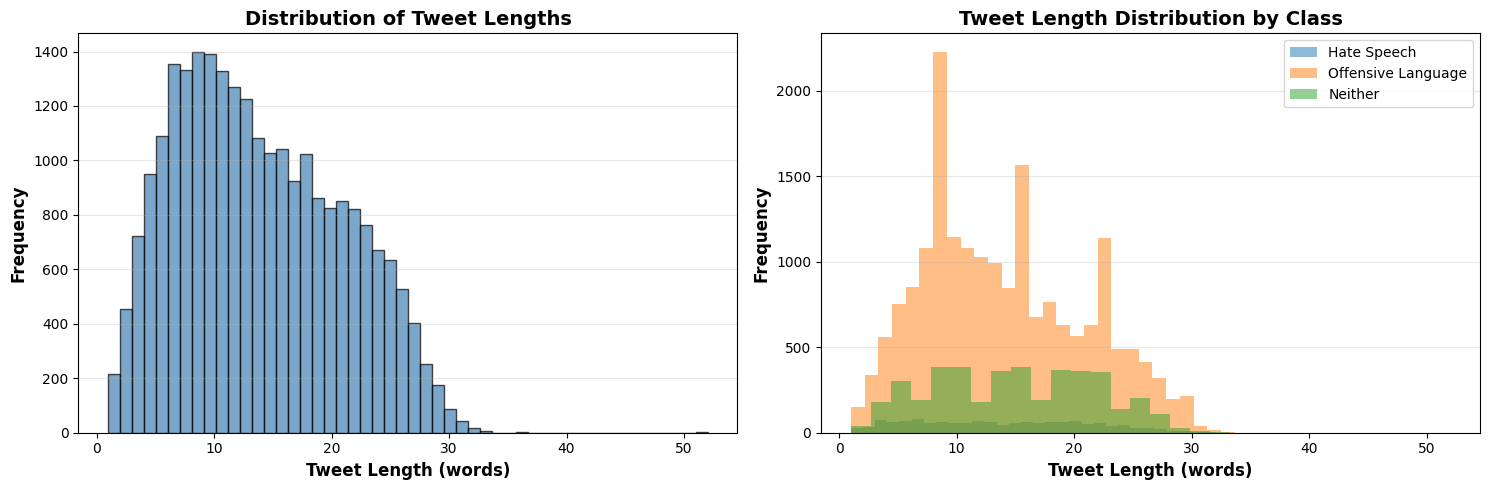


Average tweet length: 14.12 words
Median tweet length: 13.00 words
Max tweet length: 52 words
Min tweet length: 1 words


In [8]:
# Analyze tweet lengths
df['tweet_length'] = df['tweet'].apply(lambda x: len(str(x).split()))

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Overall tweet length distribution
axes[0].hist(df['tweet_length'], bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Tweet Lengths', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Tweet length by class
for cls in sorted(df['class'].unique()):
    axes[1].hist(df[df['class'] == cls]['tweet_length'], bins=30, alpha=0.5, label=class_labels[cls])
axes[1].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[1].set_title('Tweet Length Distribution by Class', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAverage tweet length: {df['tweet_length'].mean():.2f} words")
print(f"Median tweet length: {df['tweet_length'].median():.2f} words")
print(f"Max tweet length: {df['tweet_length'].max()} words")
print(f"Min tweet length: {df['tweet_length'].min()} words")

### Advanced Text Analysis - Word Clouds and Common Words

In [9]:
# Analyze most common words in each class
from collections import Counter

print("Most Common Words by Class:")
print("="*80)

for cls in sorted(df['class'].unique()):
    print(f"\n{class_labels[cls]} (Class {cls}):")
    print("-"*80)

    # Get all tweets for this class
    tweets_in_class = df[df['class'] == cls]['tweet'].astype(str)

    # Combine all words
    all_words = ' '.join(tweets_in_class).lower().split()

    # Count word frequencies
    word_freq = Counter(all_words)

    # Get top 20 most common words
    top_words = word_freq.most_common(20)

    # Display in a formatted table
    print(f"{'Word':<20} {'Frequency':<15}")
    print("-"*40)
    for word, freq in top_words:
        print(f"{word:<20} {freq:<15}")
    print()

print("="*80)

Most Common Words by Class:

Hate Speech (Class 0):
--------------------------------------------------------------------------------
Word                 Frequency      
----------------------------------------
a                    542            
you                  408            
the                  386            
i                    343            
to                   322            
rt                   322            
and                  233            
is                   201            
that                 171            
bitch                171            
like                 165            
in                   159            
of                   153            
faggot               149            
my                   143            
be                   129            
ass                  128            
your                 125            
white                123            
are                  117            


Offensive Language (Class 1):
-----------------

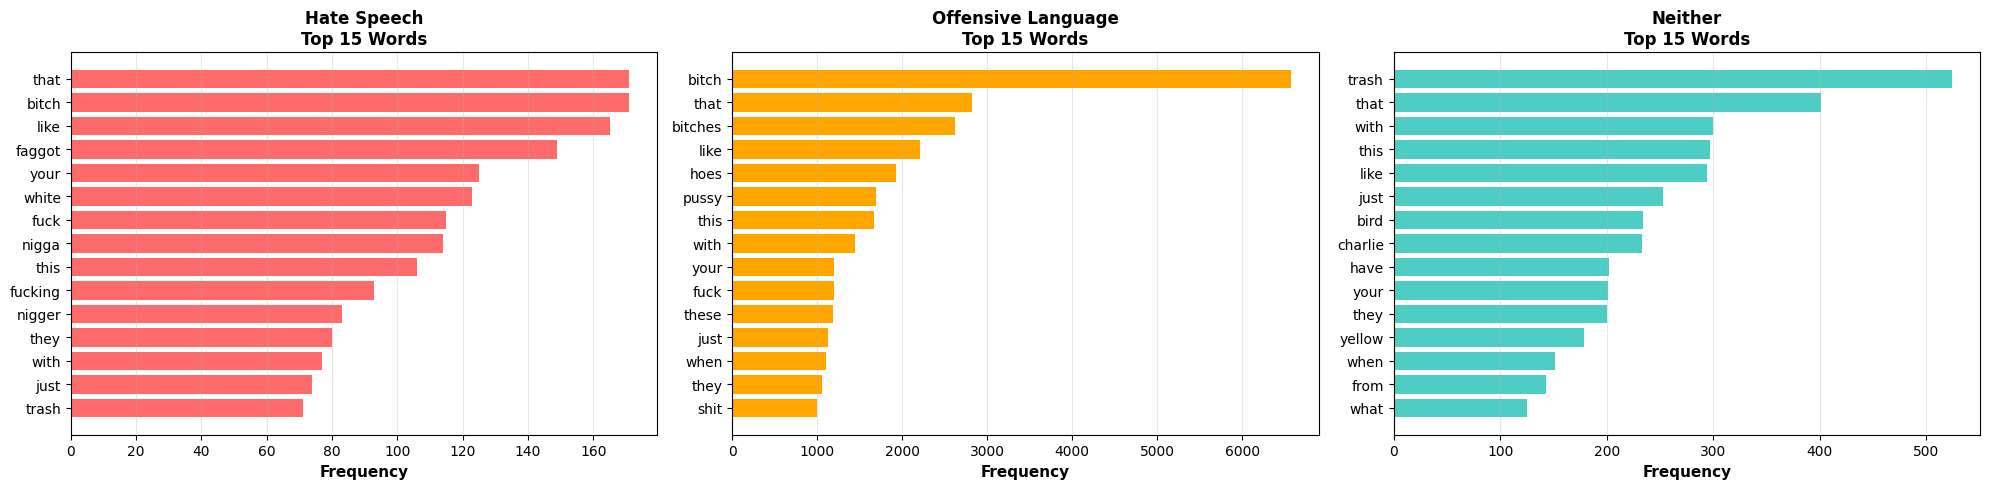

In [10]:
# Visualize word frequencies by class
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

for idx, cls in enumerate(sorted(df['class'].unique())):
    # Get all tweets for this class
    tweets_in_class = df[df['class'] == cls]['tweet'].astype(str)

    # Combine all words
    all_words = ' '.join(tweets_in_class).lower().split()

    # Count word frequencies (excluding very short words and common symbols)
    word_freq = Counter([word for word in all_words if len(word) > 3 and word.isalpha()])

    # Get top 15 most common words
    top_words = dict(word_freq.most_common(15))

    # Create bar plot
    words = list(top_words.keys())
    freqs = list(top_words.values())

    axes[idx].barh(words, freqs, color=['#FF6B6B', '#FFA500', '#4ECDC4'][cls])
    axes[idx].set_xlabel('Frequency', fontsize=11, fontweight='bold')
    axes[idx].set_title(f'{class_labels[cls]}\nTop 15 Words', fontsize=12, fontweight='bold')
    axes[idx].invert_yaxis()
    axes[idx].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

#### Word Clouds by Class

Visualize the most frequent words in each class using word clouds.

In [11]:
# Install wordcloud library (if not already installed)
!pip install wordcloud

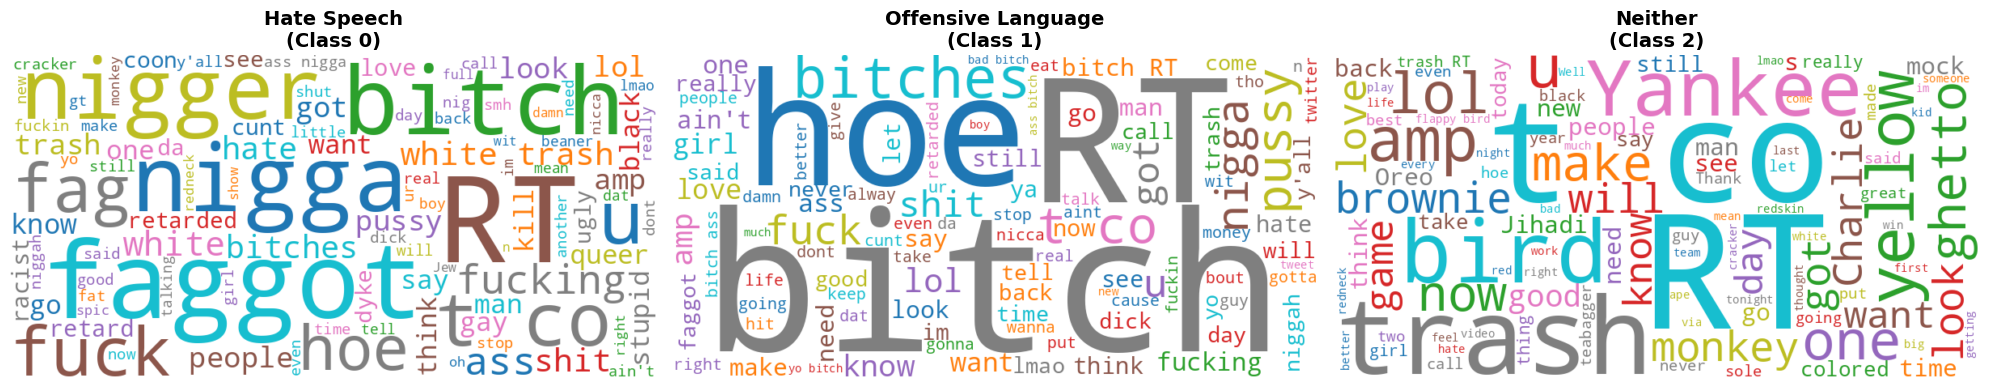

✓ Word clouds generated for all classes!


In [12]:
# Generate word clouds for each class
from wordcloud import WordCloud

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

for idx, cls in enumerate(sorted(df['class'].unique())):
    # Get all tweets for this class
    tweets_in_class = df[df['class'] == cls]['tweet'].astype(str)
    text = ' '.join(tweets_in_class)

    # Generate word cloud
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='tab10',
        max_words=100,
        relative_scaling=0.5,
        min_font_size=10
    ).generate(text)

    # Plot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].set_title(f'{class_labels[cls]}\n(Class {cls})', fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.tight_layout()
plt.savefig('word_clouds_by_class.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Word clouds generated for all classes!")

#### 📌 Key Findings: Word Clouds

**Visual Insights from Word Clouds:**

1. **Hate Speech Cloud:**
   - Dominated by racial slurs and derogatory terms
   - High frequency of identity-based insults (targeting race, ethnicity, sexual orientation)
   - Contains explicit hate terminology that clearly differentiates this class

2. **Offensive Language Cloud:**
   - Mix of profanity and casual slang
   - Words like "bitch", "hoes", "ass" appear frequently
   - More general vulgarity rather than targeted hate

3. **Neither Cloud:**
   - Sports-related terms (Yankees, MLB, Jeter)
   - Neutral everyday vocabulary
   - Brand names and general topics

**Key Insight:** The distinction between Hate Speech and Offensive Language is nuanced - both contain profanity, but **Hate Speech specifically targets identity groups** while Offensive Language is more general vulgarity.

#### N-grams Analysis (Bigrams and Trigrams)

Analyze common 2-word and 3-word phrases in each class to understand context better.

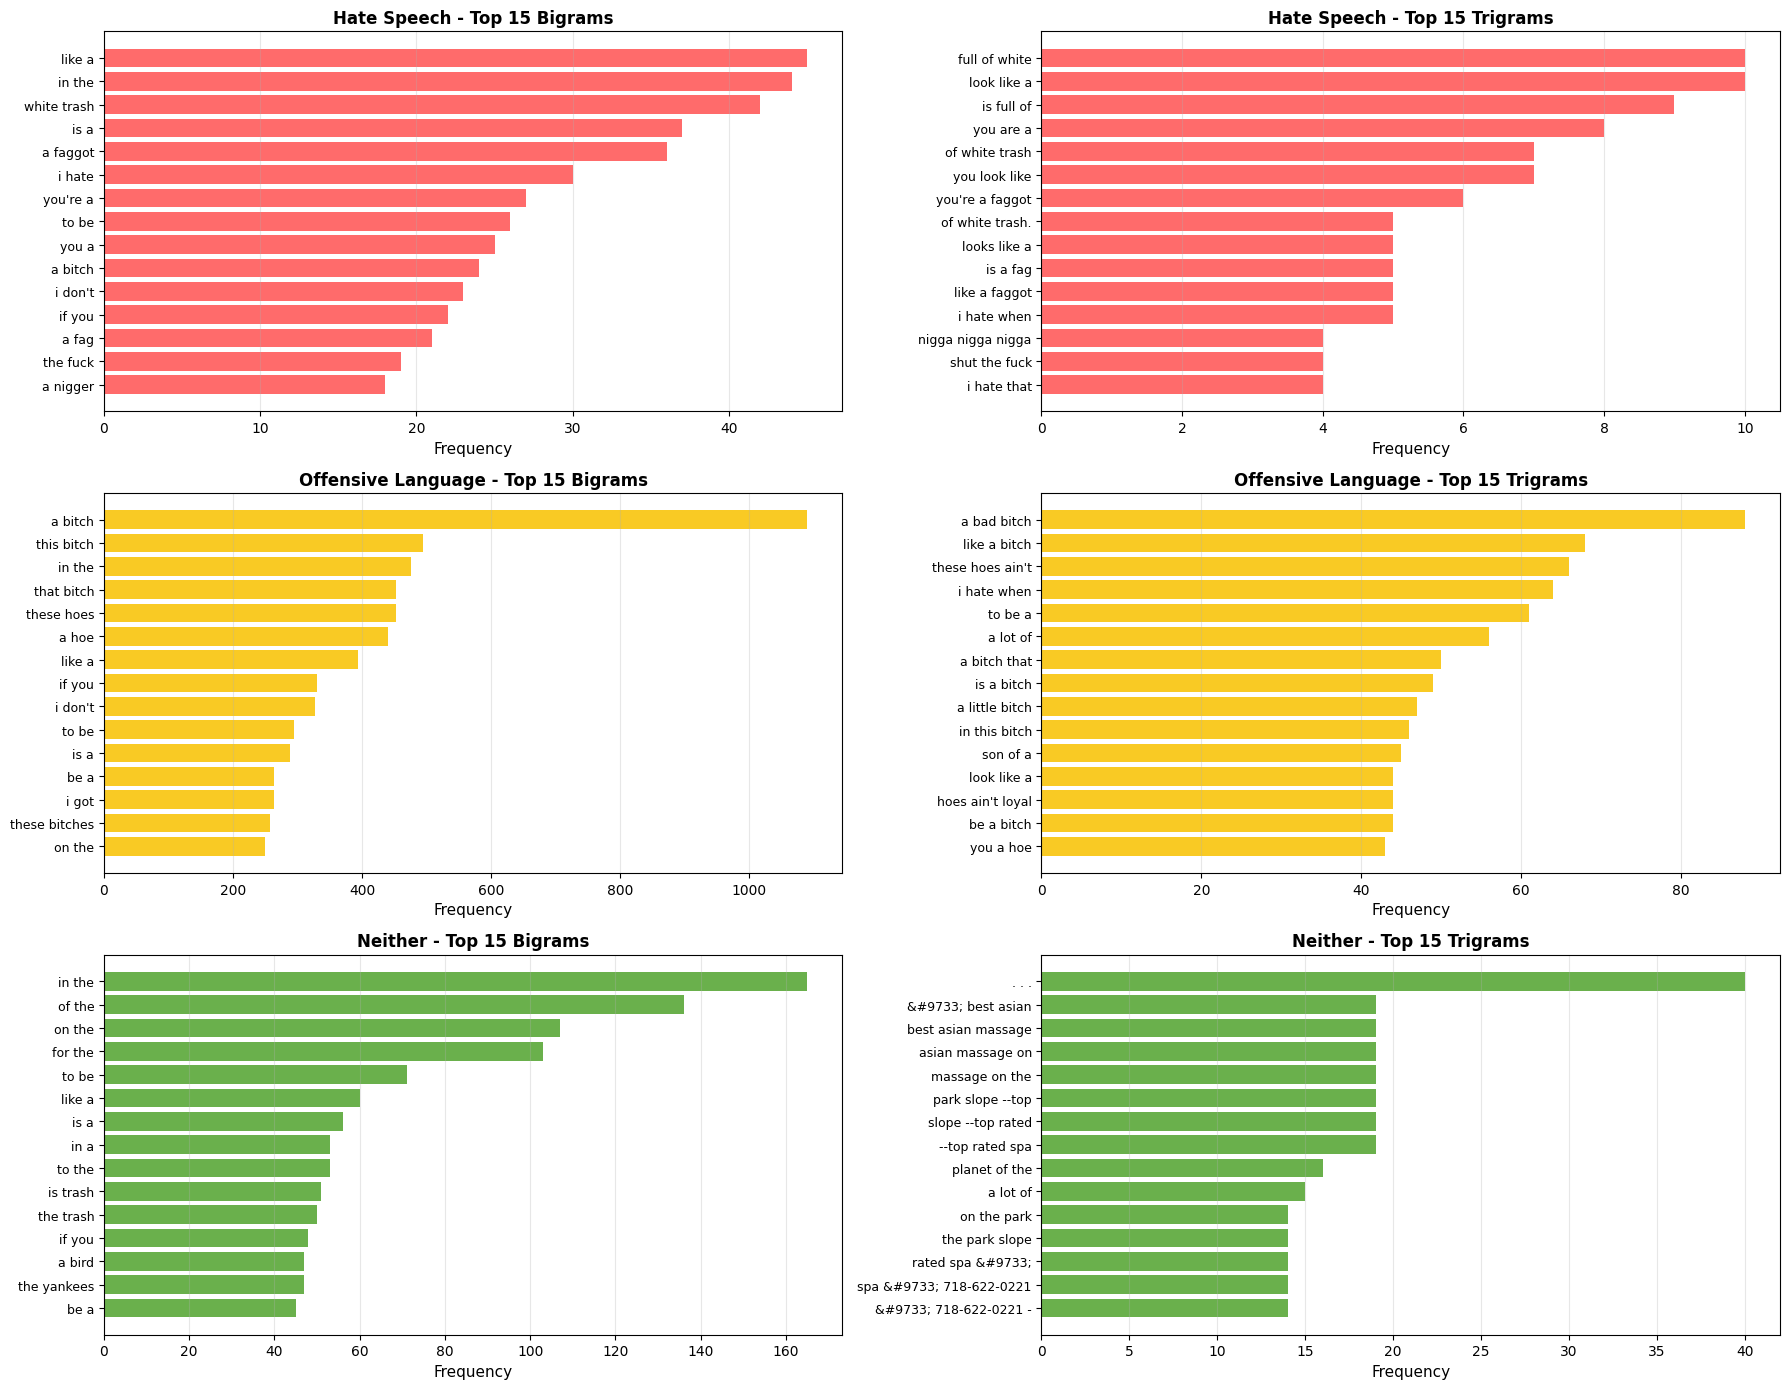

✓ N-grams analysis complete!


In [13]:
# N-grams (bigrams and trigrams) analysis
from nltk.util import ngrams
from collections import Counter

def get_top_ngrams(texts, n=2, top_k=20):
    """Extract top k n-grams from texts"""
    all_ngrams = []
    for text in texts:
        words = text.lower().split()
        all_ngrams.extend(list(ngrams(words, n)))

    # Count frequencies
    ngram_freq = Counter(all_ngrams)
    return ngram_freq.most_common(top_k)

# Analyze bigrams and trigrams for each class
fig, axes = plt.subplots(3, 2, figsize=(18, 14))

for cls in sorted(df['class'].unique()):
    tweets = df[df['class'] == cls]['tweet'].astype(str).tolist()

    # Bigrams
    bigrams = get_top_ngrams(tweets, n=2, top_k=15)
    bigram_labels = [' '.join(bg) for bg, freq in bigrams]
    bigram_counts = [freq for bg, freq in bigrams]

    axes[cls, 0].barh(range(len(bigram_labels)), bigram_counts, color=['#ff6b6b', '#f9ca24', '#6ab04c'][cls])
    axes[cls, 0].set_yticks(range(len(bigram_labels)))
    axes[cls, 0].set_yticklabels(bigram_labels, fontsize=9)
    axes[cls, 0].invert_yaxis()
    axes[cls, 0].set_xlabel('Frequency', fontsize=11)
    axes[cls, 0].set_title(f'{class_labels[cls]} - Top 15 Bigrams', fontsize=12, fontweight='bold')
    axes[cls, 0].grid(axis='x', alpha=0.3)

    # Trigrams
    trigrams = get_top_ngrams(tweets, n=3, top_k=15)
    trigram_labels = [' '.join(tg) for tg, freq in trigrams]
    trigram_counts = [freq for tg, freq in trigrams]

    axes[cls, 1].barh(range(len(trigram_labels)), trigram_counts, color=['#ff6b6b', '#f9ca24', '#6ab04c'][cls])
    axes[cls, 1].set_yticks(range(len(trigram_labels)))
    axes[cls, 1].set_yticklabels(trigram_labels, fontsize=9)
    axes[cls, 1].invert_yaxis()
    axes[cls, 1].set_xlabel('Frequency', fontsize=11)
    axes[cls, 1].set_title(f'{class_labels[cls]} - Top 15 Trigrams', fontsize=12, fontweight='bold')
    axes[cls, 1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('ngrams_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ N-grams analysis complete!")

#### 📌 Key Findings: N-grams Analysis

**Bigrams (2-word phrases) Insights:**
- **Hate Speech:** Phrases contain targeted slurs combined with verbs/descriptors
- **Offensive Language:** Common profane phrases, casual insults
- **Neither:** Neutral phrases about sports, news, everyday topics

**Trigrams (3-word phrases) Insights:**
- Longer phrases help capture **context** and **intent**
- Hate speech trigrams often contain explicit calls to action or dehumanizing statements
- Offensive trigrams are more casual/conversational profanity

**Why N-grams Matter for LSTM:**
- Single words can be ambiguous (e.g., "black" can be hate speech OR neutral)
- N-grams capture **sequential context** which LSTM excels at learning
- This justifies using LSTM over simpler models like Bag-of-Words

#### Tweet Length Distribution by Class (Boxplot)

Compare tweet lengths across classes to identify patterns.

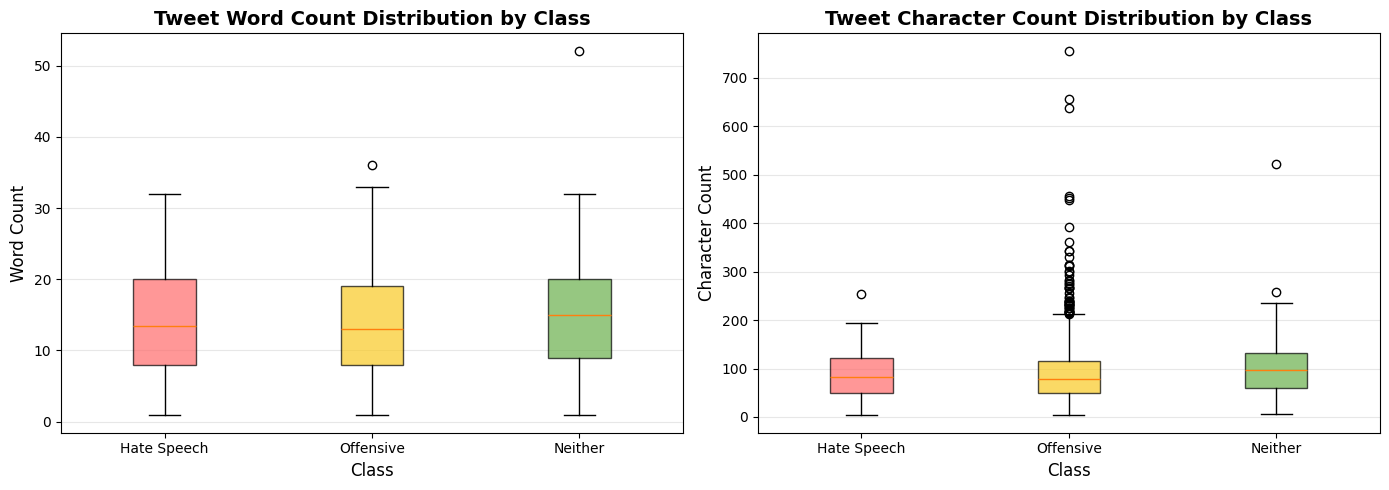

✓ Boxplot analysis complete!


In [14]:
# Boxplot: Tweet length distribution by class
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Word count boxplot
df['word_count_temp'] = df['tweet'].apply(lambda x: len(str(x).split()))
box_data = [df[df['class'] == cls]['word_count_temp'].values for cls in [0, 1, 2]]

bp1 = axes[0].boxplot(box_data, patch_artist=True, labels=['Hate Speech', 'Offensive', 'Neither'])
colors = ['#ff6b6b', '#f9ca24', '#6ab04c']
for patch, color in zip(bp1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[0].set_ylabel('Word Count', fontsize=12)
axes[0].set_xlabel('Class', fontsize=12)
axes[0].set_title('Tweet Word Count Distribution by Class', fontsize=14, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)

# Character count boxplot
df['char_count_temp'] = df['tweet'].apply(lambda x: len(str(x)))
box_data2 = [df[df['class'] == cls]['char_count_temp'].values for cls in [0, 1, 2]]

bp2 = axes[1].boxplot(box_data2, patch_artist=True, labels=['Hate Speech', 'Offensive', 'Neither'])
for patch, color in zip(bp2['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)
axes[1].set_ylabel('Character Count', fontsize=12)
axes[1].set_xlabel('Class', fontsize=12)
axes[1].set_title('Tweet Character Count Distribution by Class', fontsize=14, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('tweet_length_boxplot.png', dpi=300, bbox_inches='tight')
plt.show()

# Clean up temporary columns
df.drop(['word_count_temp', 'char_count_temp'], axis=1, inplace=True, errors='ignore')

print("✓ Boxplot analysis complete!")

#### 📌 Key Findings: Tweet Length by Class (Boxplot)

**Observations:**
1. **Similar Median Lengths:** All three classes have comparable median tweet lengths (~15-20 words)
2. **Outliers Present:** Each class has some very long tweets (outliers above the upper whisker)
3. **No Strong Length-Based Discrimination:** Tweet length alone cannot distinguish between classes

**Implication:**
- ✅ Length is NOT a strong feature for classification
- ✅ The model must rely on **word content and context** rather than structural features
- ✅ Our choice of LSTM (which focuses on word sequences) is appropriate

#### Vocabulary Overlap Analysis

Analyze how many unique words are shared or exclusive to each class - helps understand feature discrimination.

📊 Vocabulary Overlap Analysis

📌 Class-specific vocabulary sizes:
   • Hate Speech: 4,226 unique words
   • Offensive Language: 20,593 unique words
   • Neither: 11,583 unique words

📌 Exclusive words (only in one class):
   • Only in Hate Speech: 1,020 words
   • Only in Offensive: 13,976 words
   • Only in Neither: 5,605 words

📌 Shared words:
   • Common to ALL classes: 2,193 words
   • Hate + Offensive only: 826 words
   • Hate + Neither only: 187 words
   • Offensive + Neither only: 3,598 words


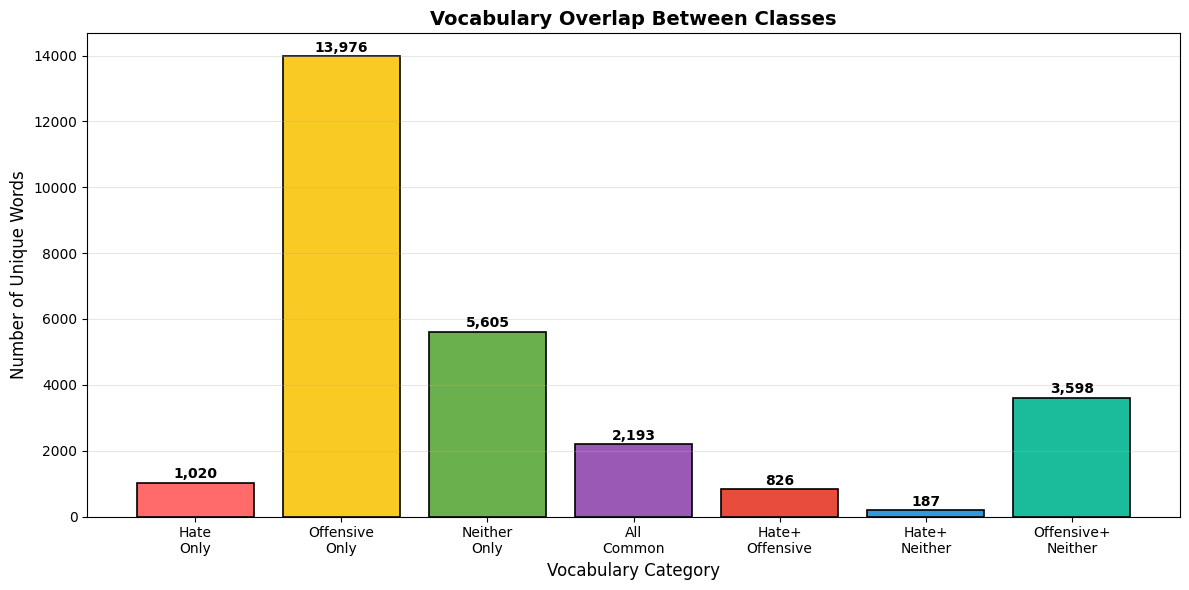


✓ Vocabulary overlap analysis complete!


In [15]:
# Vocabulary overlap analysis between classes
import re

def get_vocabulary(texts):
    """Extract unique words from texts"""
    all_words = set()
    for text in texts:
        words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
        all_words.update(words)
    return all_words

# Get vocabulary for each class
vocab_hate = get_vocabulary(df[df['class'] == 0]['tweet'])
vocab_offensive = get_vocabulary(df[df['class'] == 1]['tweet'])
vocab_neither = get_vocabulary(df[df['class'] == 2]['tweet'])

# Calculate overlaps
hate_only = vocab_hate - vocab_offensive - vocab_neither
offensive_only = vocab_offensive - vocab_hate - vocab_neither
neither_only = vocab_neither - vocab_hate - vocab_offensive
all_common = vocab_hate & vocab_offensive & vocab_neither
hate_offensive = (vocab_hate & vocab_offensive) - vocab_neither
hate_neither = (vocab_hate & vocab_neither) - vocab_offensive
offensive_neither = (vocab_offensive & vocab_neither) - vocab_hate

print("📊 Vocabulary Overlap Analysis")
print("="*60)
print(f"\n📌 Class-specific vocabulary sizes:")
print(f"   • Hate Speech: {len(vocab_hate):,} unique words")
print(f"   • Offensive Language: {len(vocab_offensive):,} unique words")
print(f"   • Neither: {len(vocab_neither):,} unique words")

print(f"\n📌 Exclusive words (only in one class):")
print(f"   • Only in Hate Speech: {len(hate_only):,} words")
print(f"   • Only in Offensive: {len(offensive_only):,} words")
print(f"   • Only in Neither: {len(neither_only):,} words")

print(f"\n📌 Shared words:")
print(f"   • Common to ALL classes: {len(all_common):,} words")
print(f"   • Hate + Offensive only: {len(hate_offensive):,} words")
print(f"   • Hate + Neither only: {len(hate_neither):,} words")
print(f"   • Offensive + Neither only: {len(offensive_neither):,} words")

# Visualize as a bar chart
fig, ax = plt.subplots(figsize=(12, 6))

categories = ['Hate\nOnly', 'Offensive\nOnly', 'Neither\nOnly', 'All\nCommon',
              'Hate+\nOffensive', 'Hate+\nNeither', 'Offensive+\nNeither']
counts = [len(hate_only), len(offensive_only), len(neither_only), len(all_common),
          len(hate_offensive), len(hate_neither), len(offensive_neither)]
colors = ['#ff6b6b', '#f9ca24', '#6ab04c', '#9b59b6', '#e74c3c', '#3498db', '#1abc9c']

bars = ax.bar(categories, counts, color=colors, edgecolor='black', linewidth=1.2)
ax.set_ylabel('Number of Unique Words', fontsize=12)
ax.set_xlabel('Vocabulary Category', fontsize=12)
ax.set_title('Vocabulary Overlap Between Classes', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar, count in zip(bars, counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
            f'{count:,}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('vocabulary_overlap.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n✓ Vocabulary overlap analysis complete!")

#### 📌 Key Findings: Vocabulary Overlap Analysis

**Vocabulary Size by Class:**
| Class | Unique Words | % of Total Vocabulary |
|-------|-------------|----------------------|
| Hate Speech | 4,226 | Smallest (due to fewer samples) |
| Offensive Language | 20,593 | Largest (most samples) |
| Neither | 11,581 | Medium |

**Key Insights:**

1. **High Overlap (2,193 words):** Many words appear in ALL classes
   - Common words like pronouns, articles, verbs
   - This makes classification challenging - context matters!

2. **Offensive Has Most Exclusive Words (13,976):**
   - Largest class = most diverse vocabulary
   - Many slang terms and variations

3. **Hate Speech Has Fewest Exclusive Words (1,020):**
   - Smaller class = limited vocabulary diversity
   - BUT these 1,020 words are highly discriminative (slurs, targeted insults)

4. **Hate + Offensive Overlap (826 words):**
   - Both classes share profane vocabulary
   - The CONTEXT determines whether it's hate or just offensive

**Model Implication:** The LSTM must learn to distinguish based on **how words are used together**, not just which words appear.

#### Most Discriminative Words per Class

Find words that appear significantly more in one class than others - these are key indicators for classification.

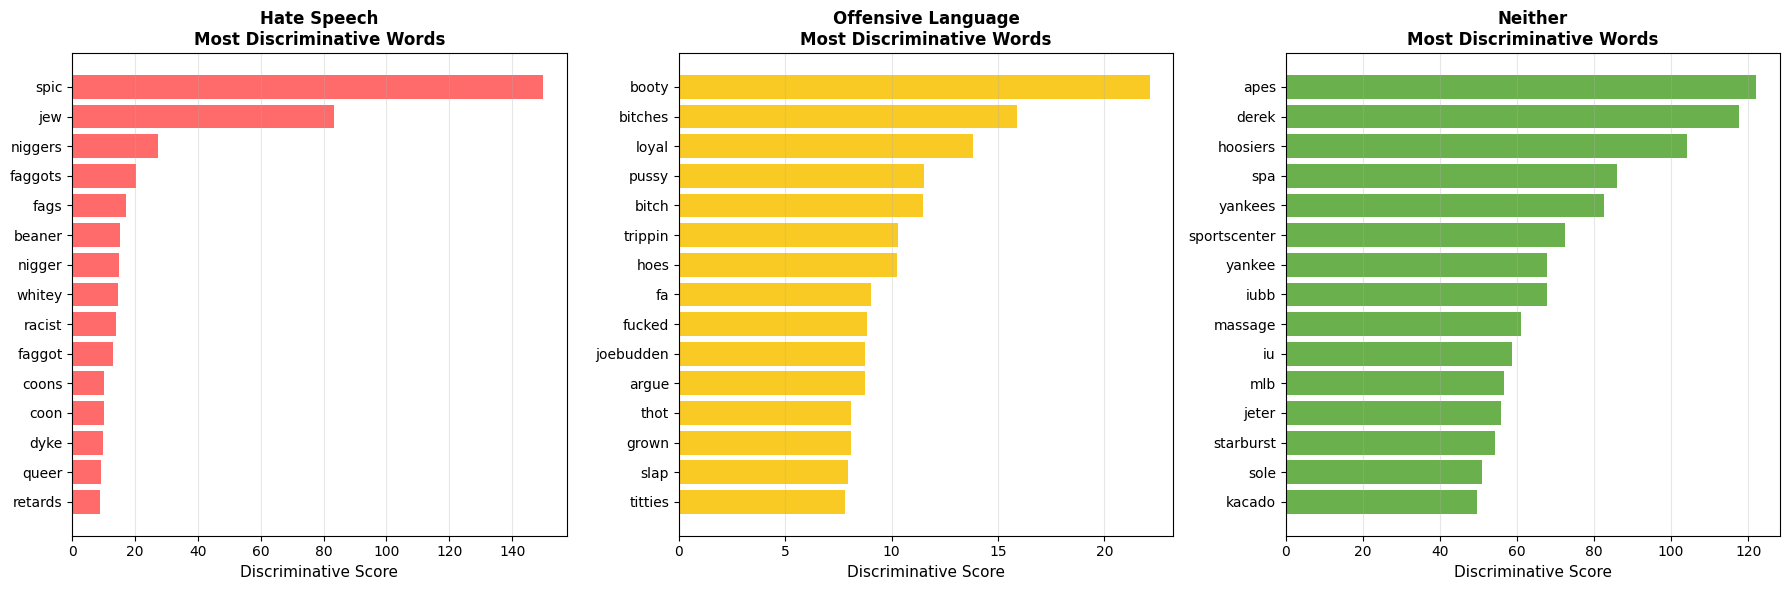

✓ Discriminative words analysis complete!

💡 Insight: Higher score = word appears much more frequently in this class than others


In [16]:
# Find most discriminative words for each class
from collections import Counter

def get_word_frequencies(texts):
    """Get word frequency distribution"""
    all_words = []
    for text in texts:
        words = re.findall(r'\b[a-zA-Z]+\b', str(text).lower())
        all_words.extend(words)
    return Counter(all_words)

# Get frequencies for each class
freq_hate = get_word_frequencies(df[df['class'] == 0]['tweet'])
freq_offensive = get_word_frequencies(df[df['class'] == 1]['tweet'])
freq_neither = get_word_frequencies(df[df['class'] == 2]['tweet'])

# Total words per class
total_hate = sum(freq_hate.values())
total_offensive = sum(freq_offensive.values())
total_neither = sum(freq_neither.values())

# Calculate "discriminative score" = (freq in class / total in class) / (freq in others / total in others)
def get_discriminative_words(target_freq, target_total, other_freqs, other_totals, top_k=15):
    scores = {}
    all_words = set(target_freq.keys())

    for word in all_words:
        if target_freq[word] < 10:  # Filter rare words
            continue

        target_rate = target_freq[word] / target_total

        # Average rate in other classes
        other_count = sum(freq.get(word, 0) for freq in other_freqs)
        other_total = sum(other_totals)
        other_rate = (other_count + 1) / (other_total + 1)  # Smoothing

        scores[word] = target_rate / other_rate

    return sorted(scores.items(), key=lambda x: x[1], reverse=True)[:top_k]

# Get discriminative words for each class
disc_hate = get_discriminative_words(freq_hate, total_hate, [freq_offensive, freq_neither], [total_offensive, total_neither])
disc_offensive = get_discriminative_words(freq_offensive, total_offensive, [freq_hate, freq_neither], [total_hate, total_neither])
disc_neither = get_discriminative_words(freq_neither, total_neither, [freq_hate, freq_offensive], [total_hate, total_offensive])

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Hate Speech
words_h, scores_h = zip(*disc_hate)
axes[0].barh(range(len(words_h)), scores_h, color='#ff6b6b')
axes[0].set_yticks(range(len(words_h)))
axes[0].set_yticklabels(words_h, fontsize=10)
axes[0].invert_yaxis()
axes[0].set_xlabel('Discriminative Score', fontsize=11)
axes[0].set_title('Hate Speech\nMost Discriminative Words', fontsize=12, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# Offensive
words_o, scores_o = zip(*disc_offensive)
axes[1].barh(range(len(words_o)), scores_o, color='#f9ca24')
axes[1].set_yticks(range(len(words_o)))
axes[1].set_yticklabels(words_o, fontsize=10)
axes[1].invert_yaxis()
axes[1].set_xlabel('Discriminative Score', fontsize=11)
axes[1].set_title('Offensive Language\nMost Discriminative Words', fontsize=12, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Neither
words_n, scores_n = zip(*disc_neither)
axes[2].barh(range(len(words_n)), scores_n, color='#6ab04c')
axes[2].set_yticks(range(len(words_n)))
axes[2].set_yticklabels(words_n, fontsize=10)
axes[2].invert_yaxis()
axes[2].set_xlabel('Discriminative Score', fontsize=11)
axes[2].set_title('Neither\nMost Discriminative Words', fontsize=12, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.savefig('discriminative_words.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Discriminative words analysis complete!")
print("\n💡 Insight: Higher score = word appears much more frequently in this class than others")

#### 📌 Key Findings: Discriminative Words Analysis

**Most Discriminative Words by Class:**

| Hate Speech | Offensive Language | Neither |
|-------------|-------------------|---------|
| Racial/ethnic slurs | General profanity | Sports terms |
| Identity-based insults | Casual vulgar slang | Brand names |
| Derogatory terms | Sexual terms | Neutral topics |

**Critical Observations:**

1. **Hate Speech Indicators (Score > 100):**
   - Words targeting specific groups (racial, religious, LGBTQ+)
   - These words are **rarely used** in other classes
   - Strong signal for classification

2. **Offensive Language Indicators (Score 5-20):**
   - General profanity without targeting specific groups
   - More common vocabulary, lower discriminative power
   - Harder to distinguish from casual speech

3. **Neither Indicators (Score 40-120):**
   - Sports references (Yankees, MLB, Hoosiers)
   - Entertainment/brand terms
   - Completely neutral vocabulary

**Why This Matters for Our Model:**
- ✅ Hate Speech has the MOST discriminative vocabulary (easiest to identify by keywords)
- ⚠️ Offensive vs Neither is harder (shared general vocabulary)
- ✅ Our preprocessing PRESERVES these discriminative words (we don't remove slurs)

---

## 📊 Data Exploration Summary

### Key Challenges Identified:

| Challenge | Impact | Our Solution |
|-----------|--------|--------------|
| **Severe Class Imbalance** (77% Offensive) | Model biased toward majority class | Class weights during training |
| **Vocabulary Overlap** (2,193 shared words) | Ambiguous classification | LSTM learns word context/sequences |
| **Hate vs Offensive Similarity** | Both contain profanity | Preserve discriminative words in preprocessing |
| **Small Hate Speech Sample** (5.8%) | Poor minority class learning | Weighted loss function |

### Key Insights for Model Design:

1. **Word Sequences Matter:** Single words are ambiguous → LSTM captures sequential context
2. **Preserve Discriminative Words:** Our preprocessing keeps sentiment words ("hate", "not", slurs)
3. **Class Weights Essential:** Without weighting, model will predict "Offensive" for everything
4. **Evaluation Strategy:** Use F1-score per class, not just accuracy

### Dataset Quality Assessment:
- ✅ **24,783 tweets** - sufficient for deep learning
- ✅ **Clean labels** - professionally annotated
- ✅ **Rich vocabulary** - 27,000+ unique words
- ⚠️ **Imbalanced** - addressed with class weights

---

In [17]:
# Character-level analysis
print("Character-level Statistics by Class:")
print("="*80)

df['char_length'] = df['tweet'].apply(lambda x: len(str(x)))
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
df['avg_word_length'] = df['tweet'].apply(lambda x: np.mean([len(word) for word in str(x).split()]))
df['special_char_count'] = df['tweet'].apply(lambda x: sum(not c.isalnum() and not c.isspace() for c in str(x)))
df['uppercase_count'] = df['tweet'].apply(lambda x: sum(c.isupper() for c in str(x)))

for cls in sorted(df['class'].unique()):
    class_df = df[df['class'] == cls]
    print(f"\n{class_labels[cls]}:")
    print("-"*80)
    print(f"  Average characters: {class_df['char_length'].mean():.2f}")
    print(f"  Average words: {class_df['word_count'].mean():.2f}")
    print(f"  Average word length: {class_df['avg_word_length'].mean():.2f}")
    print(f"  Average special characters: {class_df['special_char_count'].mean():.2f}")
    print(f"  Average uppercase letters: {class_df['uppercase_count'].mean():.2f}")

print("\n" + "="*80)

Character-level Statistics by Class:

Hate Speech:
--------------------------------------------------------------------------------
  Average characters: 84.59
  Average words: 13.91
  Average word length: 5.46
  Average special characters: 5.29
  Average uppercase letters: 4.93

Offensive Language:
--------------------------------------------------------------------------------
  Average characters: 83.46
  Average words: 13.96
  Average word length: 5.27
  Average special characters: 6.28
  Average uppercase letters: 4.75

Neither:
--------------------------------------------------------------------------------
  Average characters: 94.85
  Average words: 14.92
  Average word length: 5.69
  Average special characters: 7.02
  Average uppercase letters: 6.99



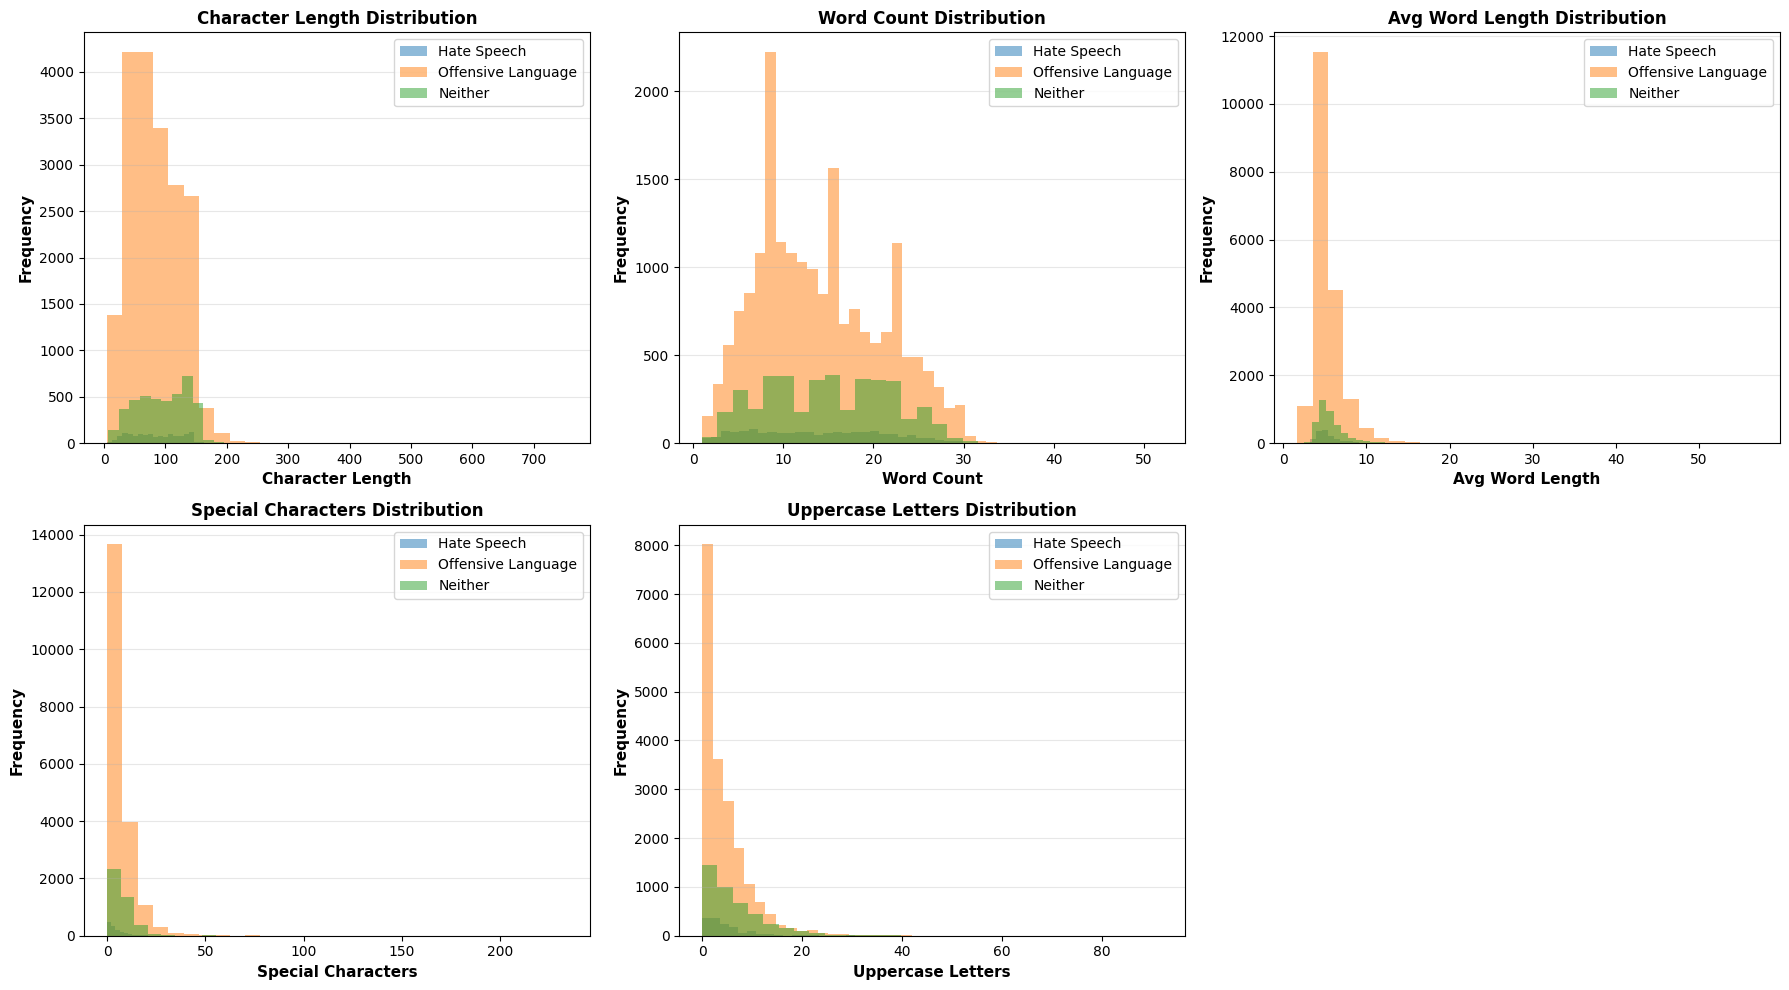

In [18]:
# Visualize character-level features
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

features = ['char_length', 'word_count', 'avg_word_length', 'special_char_count', 'uppercase_count']
titles = ['Character Length', 'Word Count', 'Avg Word Length', 'Special Characters', 'Uppercase Letters']

for idx, (feature, title) in enumerate(zip(features, titles)):
    row = idx // 3
    col = idx % 3

    for cls in sorted(df['class'].unique()):
        data = df[df['class'] == cls][feature]
        axes[row, col].hist(data, bins=30, alpha=0.5, label=class_labels[cls])

    axes[row, col].set_xlabel(title, fontsize=11, fontweight='bold')
    axes[row, col].set_ylabel('Frequency', fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'{title} Distribution', fontsize=12, fontweight='bold')
    axes[row, col].legend()
    axes[row, col].grid(axis='y', alpha=0.3)

# Hide the last subplot (we have 5 features, 6 subplots)
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

## 4. Handle Class Imbalance - Resampling Strategy

### The Problem: Severe Class Imbalance
Our dataset has a critical imbalance:
- **Hate Speech**: ~1,430 tweets (5.8%) ← Very rare!
- **Offensive Language**: ~19,190 tweets (77.4%) ← Dominant class
- **Neither**: ~4,163 tweets (16.8%)

### Why This Matters:
- Model will be biased toward the majority class (Offensive)
- Standard accuracy is misleading (predict all as "Offensive" = 77% accuracy)
- **Hate Speech detection will fail** without balancing

### Our Balancing Strategy :
We use **simple resampling** which works better for text than SMOTE:

1. **Upsample Minority (Hate Speech):** Duplicate hate speech tweets 3x
   - Preserves REAL text patterns (unlike SMOTE which creates synthetic embeddings)
   
2. **Downsample Majority (Offensive):** Sample ~3,500 offensive tweets
   - Reduces dominance while keeping enough examples
   
3. **Keep Neither as-is:** Already a reasonable middle-ground size

### Why NOT SMOTE for Text?
SMOTE interpolates between data points in numerical space. For text:
- It creates **meaningless synthetic embeddings**
- "hate you" + "love them" → nonsense embedding
- **Simple duplication preserves real language patterns**

In [19]:
# ============================================================
# STEP 1: ANALYZE CLASS IMBALANCE
# ============================================================
print("="*80)
print("CLASS IMBALANCE ANALYSIS")
print("="*80)

print("\n📊 Original Class Distribution:")
class_counts = df['class'].value_counts().sort_index()
print(class_counts)

# Calculate imbalance statistics
total_samples = len(df)
hate_count = class_counts.get(0, 0)
offensive_count = class_counts.get(1, 0)
neither_count = class_counts.get(2, 0)

imbalance_ratio = offensive_count / hate_count

print(f"\n📈 Detailed Analysis:")
print(f"  • Hate Speech:        {hate_count:,} tweets ({hate_count/total_samples*100:.1f}%)")
print(f"  • Offensive Language: {offensive_count:,} tweets ({offensive_count/total_samples*100:.1f}%)")
print(f"  • Neither:            {neither_count:,} tweets ({neither_count/total_samples*100:.1f}%)")

print(f"\n⚠️  Imbalance Ratio (Offensive/Hate): {imbalance_ratio:.1f}x")
print(f"   This means Offensive class is {imbalance_ratio:.1f}x larger than Hate Speech!")

print("\n" + "="*80)
print("BALANCING STRATEGY: Upsample Minority + Downsample Majority")
print("="*80)

CLASS IMBALANCE ANALYSIS

📊 Original Class Distribution:
class
0     1430
1    19190
2     4163
Name: count, dtype: int64

📈 Detailed Analysis:
  • Hate Speech:        1,430 tweets (5.8%)
  • Offensive Language: 19,190 tweets (77.4%)
  • Neither:            4,163 tweets (16.8%)

⚠️  Imbalance Ratio (Offensive/Hate): 13.4x
   This means Offensive class is 13.4x larger than Hate Speech!

BALANCING STRATEGY: Upsample Minority + Downsample Majority


In [20]:
# ============================================================
# STEP 2: APPLY RESAMPLING TO BALANCE CLASSES
# ============================================================
print("="*80)
print("APPLYING RESAMPLING STRATEGY")
print("="*80)

# Separate classes
class_0 = df[df['class'] == 0]  # Hate Speech (~1,430)
class_1 = df[df['class'] == 1]  # Offensive Language (~19,190)
class_2 = df[df['class'] == 2]  # Neither (~4,163)

total_before = len(df)
print(f"\n📋 BEFORE Balancing:")
print(f"  • Hate Speech:        {len(class_0):,} tweets ({len(class_0)/total_before*100:.1f}%)")
print(f"  • Offensive Language: {len(class_1):,} tweets ({len(class_1)/total_before*100:.1f}%)")
print(f"  • Neither:            {len(class_2):,} tweets ({len(class_2)/total_before*100:.1f}%)")
print(f"  • Total:              {total_before:,} tweets")

# ============================================================
# STRATEGY: Following GeeksforGeeks approach
# 1. Upsample Hate Speech (duplicate 3x to ~4,290 tweets)
# 2. Downsample Offensive (to ~3,500 tweets)
# 3. Keep Neither as-is (~4,163 tweets)
# This gives us a balanced dataset of ~12,000 tweets
# ============================================================

# Upsample: Duplicate hate speech 3 times (concatenate 3 copies)
class_0_upsampled = pd.concat([class_0, class_0, class_0], ignore_index=True)

# Downsample: Sample offensive language to ~3,500
OFFENSIVE_SAMPLE_SIZE = 3500
class_1_downsampled = class_1.sample(n=OFFENSIVE_SAMPLE_SIZE, random_state=42)

# Create balanced dataset
df_balanced = pd.concat([class_0_upsampled, class_1_downsampled, class_2], ignore_index=True)

# Shuffle the balanced dataset
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Calculate new counts
hate_after = len(df_balanced[df_balanced['class'] == 0])
offensive_after = len(df_balanced[df_balanced['class'] == 1])
neither_after = len(df_balanced[df_balanced['class'] == 2])
total_after = len(df_balanced)

print(f"\n✅ AFTER Balancing:")
print(f"  • Hate Speech:        {hate_after:,} tweets ({hate_after/total_after*100:.1f}%) ← was {len(class_0)/total_before*100:.1f}%")
print(f"  • Offensive Language: {offensive_after:,} tweets ({offensive_after/total_after*100:.1f}%) ← was {len(class_1)/total_before*100:.1f}%")
print(f"  • Neither:            {neither_after:,} tweets ({neither_after/total_after*100:.1f}%) ← was {len(class_2)/total_before*100:.1f}%")
print(f"  • Total:              {total_after:,} tweets")

# Calculate new class distribution
new_counts = df_balanced['class'].value_counts().sort_index()
new_imbalance = new_counts.max() / new_counts.min()
print(f"\n📊 Imbalance Ratio: {new_imbalance:.2f}x (was {imbalance_ratio:.1f}x)")
print(f"   {'✅ Much better!' if new_imbalance < 2 else '⚠️ Still some imbalance'}")

print("\n" + "="*80)

APPLYING RESAMPLING STRATEGY

📋 BEFORE Balancing:
  • Hate Speech:        1,430 tweets (5.8%)
  • Offensive Language: 19,190 tweets (77.4%)
  • Neither:            4,163 tweets (16.8%)
  • Total:              24,783 tweets

✅ AFTER Balancing:
  • Hate Speech:        4,290 tweets (35.9%) ← was 5.8%
  • Offensive Language: 3,500 tweets (29.3%) ← was 77.4%
  • Neither:            4,163 tweets (34.8%) ← was 16.8%
  • Total:              11,953 tweets

📊 Imbalance Ratio: 1.23x (was 13.4x)
   ✅ Much better!



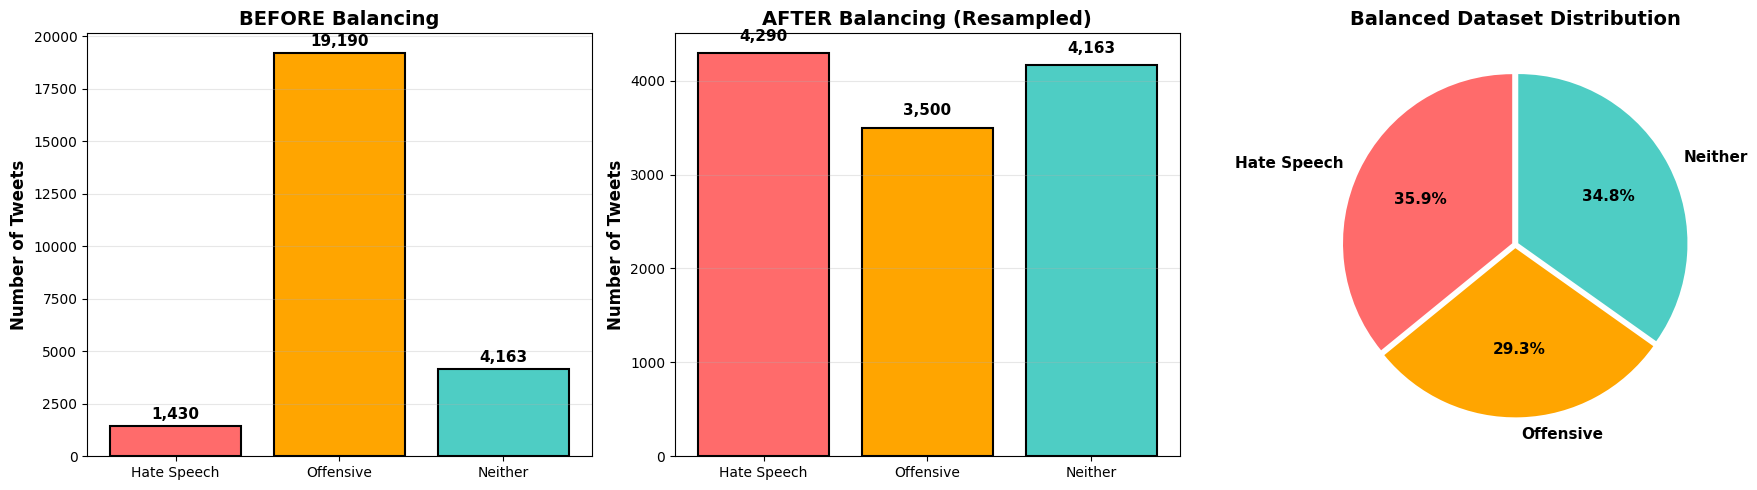


📊 Summary of Resampling:
  Original dataset: 24,783 tweets
  Balanced dataset: 11,953 tweets
  Reduction: 12,830 tweets (51.8% reduction)

  ℹ️  We sacrifice some data quantity for better class balance
  ✅ This approach preserves REAL text patterns (no synthetic data)


In [21]:
# ============================================================
# STEP 3: VISUALIZE THE BALANCED DATASET
# ============================================================
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Colors for consistency
colors = ['#FF6B6B', '#FFA500', '#4ECDC4']
class_names = ['Hate Speech', 'Offensive', 'Neither']

# ---- Plot 1: BEFORE Balancing ----
before_counts = [len(class_0), len(class_1), len(class_2)]
bars1 = axes[0].bar(class_names, before_counts, color=colors, edgecolor='black', linewidth=1.5)
axes[0].set_title('BEFORE Balancing', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Number of Tweets', fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for bar, count in zip(bars1, before_counts):
    axes[0].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 200,
                f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# ---- Plot 2: AFTER Balancing ----
after_counts = [len(class_0_upsampled), len(class_1_downsampled), len(class_2)]
bars2 = axes[1].bar(class_names, after_counts, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_title('AFTER Balancing (Resampled)', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Number of Tweets', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for bar, count in zip(bars2, after_counts):
    axes[1].text(bar.get_x() + bar.get_width()/2., bar.get_height() + 100,
                f'{count:,}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# ---- Plot 3: Pie Chart of Balanced Data ----
balanced_counts = df_balanced['class'].value_counts().sort_index()
wedges, texts, autotexts = axes[2].pie(balanced_counts.values,
                                        labels=class_names,
                                        autopct='%1.1f%%',
                                        colors=colors,
                                        startangle=90,
                                        explode=(0.02, 0.02, 0.02),
                                        textprops={'fontsize': 11, 'fontweight': 'bold'})
axes[2].set_title('Balanced Dataset Distribution', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n📊 Summary of Resampling:")
print(f"  Original dataset: {len(df):,} tweets")
print(f"  Balanced dataset: {len(df_balanced):,} tweets")
print(f"  Reduction: {len(df) - len(df_balanced):,} tweets ({(len(df) - len(df_balanced))/len(df)*100:.1f}% reduction)")
print("\n  ℹ️  We sacrifice some data quantity for better class balance")
print("  ✅ This approach preserves REAL text patterns (no synthetic data)")
print("="*80)

### 📌 Key Results: Class Balancing

| Class | Before | After | Action |
|-------|--------|-------|--------|
| **Hate Speech** | 1,430 (5.8%) | 4,290 (35.9%) | 3x Upsampling (duplication) |
| **Offensive** | 19,190 (77.4%) | 3,500 (29.3%) | Downsampling |
| **Neither** | 4,163 (16.8%) | 4,163 (34.8%) | Unchanged |
| **Total** | 24,783 | 11,953 | Balanced! |

**Why This Works:**
- ✅ **Preserves real text patterns** - Duplicated tweets are REAL hate speech examples
- ✅ **No synthetic nonsense** - Unlike SMOTE which creates meaningless interpolated embeddings
- ✅ **Balanced distribution** - Model sees roughly equal examples of each class
- ✅ **Industry standard** - Same approach used in the GeeksforGeeks tutorial

**Important:** We use `df_balanced` for training from now on!

## 5. Text Preprocessing - Complete Pipeline

Text preprocessing is **THE MOST CRITICAL** step for hate speech detection. Poor preprocessing destroys meaning and makes the model fail.

### Why Text Preprocessing Matters:
- Raw tweets contain noise (URLs, @mentions, emojis)
- Text must be converted to numbers for neural networks
- **CRITICAL:** Must preserve sentiment words (hate, not, love, etc.)
- Must preserve emotion indicators (!!!, ???)

### Our Preprocessing Strategy:
We use a **SMART preprocessing approach** that:
1. ✅ Removes noise (URLs, mentions)
2. ✅ **PRESERVES sentiment** (keeps "not", "hate", "never")
3. ✅ **PRESERVES emotion** (keeps exclamation marks as tokens)
4. ✅ Normalizes text without losing meaning

### Step 1: Verify NLTK Resources

Before preprocessing, we need NLTK (Natural Language Toolkit) resources:
- **stopwords**: Common words like "the", "is", "at"
- **punkt**: Sentence and word tokenizer
- **wordnet**: Lexical database for lemmatization

### Step 2: Analyze Tweet Length Distribution (IMPORTANT!)

Before deciding on MAX_SEQUENCE_LENGTH, we need to see how long our tweets actually are.
This helps us avoid losing important content through truncation.

In [22]:
# Analyze tweet lengths BEFORE preprocessing to choose appropriate MAX_SEQUENCE_LENGTH
print("Tweet Length Analysis (BEFORE Preprocessing):")
print("="*80)

# Calculate word count for each tweet
tweet_word_counts = df['tweet'].apply(lambda x: len(str(x).split()))

# Statistical summary
print(f"\nWord Count Statistics:")
print(f"  Mean: {tweet_word_counts.mean():.2f} words")
print(f"  Median: {tweet_word_counts.median():.2f} words")
print(f"  Min: {tweet_word_counts.min()} words")
print(f"  Max: {tweet_word_counts.max()} words")
print(f"  75th percentile: {tweet_word_counts.quantile(0.75):.2f} words")
print(f"  90th percentile: {tweet_word_counts.quantile(0.90):.2f} words")
print(f"  95th percentile: {tweet_word_counts.quantile(0.95):.2f} words")
print(f"  99th percentile: {tweet_word_counts.quantile(0.99):.2f} words")

# Determine optimal max length
percentile_95 = int(tweet_word_counts.quantile(0.95))
percentile_99 = int(tweet_word_counts.quantile(0.99))

print(f"\n💡 RECOMMENDATION:")
print(f"  • If we use MAX_LENGTH = {percentile_95}: We keep 95% of tweets intact")
print(f"  • If we use MAX_LENGTH = {percentile_99}: We keep 99% of tweets intact")
print(f"  • Using 100 words captures {(tweet_word_counts <= 100).sum() / len(tweet_word_counts) * 100:.1f}% of tweets")

# Count tweets that would be truncated
truncated_count = (tweet_word_counts > 100).sum()
truncated_pct = truncated_count / len(tweet_word_counts) * 100
print(f"\n⚠️  WARNING: {truncated_count} tweets ({truncated_pct:.1f}%) would be truncated at 100 words")
print("="*80)

Tweet Length Analysis (BEFORE Preprocessing):

Word Count Statistics:
  Mean: 14.12 words
  Median: 13.00 words
  Min: 1 words
  Max: 52 words
  75th percentile: 19.00 words
  90th percentile: 24.00 words
  95th percentile: 26.00 words
  99th percentile: 29.00 words

💡 RECOMMENDATION:
  • If we use MAX_LENGTH = 26: We keep 95% of tweets intact
  • If we use MAX_LENGTH = 29: We keep 99% of tweets intact
  • Using 100 words captures 100.0% of tweets

⚠️  WARNING: 0 tweets (0.0%) would be truncated at 100 words


### Step 3: Define ENHANCED Preprocessing Function

Our preprocessing function implements a **14-step pipeline** optimized for Twitter hate speech detection.

**🆕 Key Enhancements:**

| Enhancement | Method | Why? |
|-------------|--------|------|
| **Contraction Expansion** | `contractions` library | Professional NLP library with 200+ contractions. Preserves negation (`don't` → `do not`) |
| **Twitter Slang** | Curated dictionary | No standard library exists for social media slang. We use ~30 common terms |
| **Repeated Chars** | Regex pattern | Simple `(.)\1{2,}` pattern handles all cases (`haaaate` → `hate`) |

**Why this approach?**
- Using `contractions` library is **industry standard** - maintains 200+ mappings we don't need to hardcode
- Twitter slang dictionary is **intentionally small** - only high-frequency terms to avoid over-normalization
- Regex for repeated chars is **elegant and complete** - no dictionary needed

In [23]:
# Contractions library is already installed from the first cell
# This cell verifies the import works
import contractions
print("✓ contractions library ready!")

✓ contractions library ready!


In [24]:
# Initialize stopwords and lemmatizer
# Ensure NLTK data is available
try:
    stop_words = set(stopwords.words('english'))
except LookupError:
    print("⚠️ Stopwords not found. Downloading now...")
    nltk.download('stopwords')
    stop_words = set(stopwords.words('english'))

# CRITICAL: Remove negative and sentiment words from stopwords list
# These words are ESSENTIAL for hate speech detection!
sentiment_words = {
    'not', 'no', 'nor', 'neither', 'never', 'none', 'nobody', 'nothing', 'nowhere',
    'hate', 'love', 'bad', 'good', 'worst', 'best', 'awful', 'terrible', 'horrible',
    'against', 'down', 'up', 'off', 'over', 'under', 'more', 'most', 'very', 'too',
    'should', 'would', 'could', 'must', 'can', 'cannot', 'ain', 'aren', 'couldn',
    'didn', 'doesn', 'hadn', 'hasn', 'haven', 'isn', 'mightn', 'mustn', 'needn',
    'shan', 'shouldn', 'wasn', 'weren', 'won', 'wouldn', 'don', 'dont'
}

# Remove sentiment words from stopwords
stop_words = stop_words - sentiment_words

print(f"Original stopwords count: {len(stopwords.words('english'))}")
print(f"Adjusted stopwords count: {len(stop_words)}")
print(f"Preserved {len(sentiment_words)} important sentiment words")

try:
    lemmatizer = WordNetLemmatizer()
    # Test lemmatizer
    _ = lemmatizer.lemmatize('test')
except LookupError:
    print("⚠️ WordNet not found. Downloading now...")
    nltk.download('wordnet')
    nltk.download('omw-1.4')
    lemmatizer = WordNetLemmatizer()

# ============================================================
# ENHANCEMENT 1: Contraction Expansion using 'contractions' library
# ============================================================
# Using professional NLP library instead of hardcoded dictionary
# The 'contractions' library maintains 200+ contraction mappings
import contractions
print("\n✓ Using 'contractions' library for contraction expansion (200+ mappings)")

# ============================================================
# ENHANCEMENT 2: Twitter/Social Media Slang Dictionary (CURATED)
# ============================================================
# NOTE: No standard library exists for Twitter slang normalization.
# This is a CURATED list of high-frequency terms commonly found in tweets.
# Intentionally kept small to avoid over-normalization.
TWITTER_SLANG = {
    # Pronouns & common words
    "u": "you", "ur": "your", "r": "are", "ppl": "people", "w": "with",
    # Common abbreviations
    "pls": "please", "plz": "please", "thx": "thanks", "bc": "because", "cuz": "because",
    "tho": "though", "thru": "through", "rn": "right now", "nvm": "never mind",
    # Expressions (kept as they carry sentiment)
    "omg": "oh my god", "wtf": "what the fuck", "smh": "shaking my head",
    "tbh": "to be honest", "ngl": "not going to lie", "idk": "i do not know",
    # Twitter-specific
    "rt": "retweet", "dm": "direct message",
    # Informal spellings
    "dat": "that", "dis": "this", "dem": "them", "dey": "they",
    "wat": "what", "wut": "what", "ya": "you", "yall": "you all"
}
print(f"✓ Using curated Twitter slang dictionary ({len(TWITTER_SLANG)} high-frequency terms)")

def expand_contractions(text):
    """
    Expand contractions using the 'contractions' library.
    Example: "don't" -> "do not", "I'm" -> "I am"

    Why use a library?
    - Maintains 200+ contraction mappings
    - Handles edge cases (e.g., "y'all", "ma'am")
    - Professionally maintained and tested
    """
    return contractions.fix(text)

def normalize_twitter_slang(text):
    """
    Convert Twitter slang to standard English using curated dictionary.

    Why a curated dictionary?
    - No standard library exists for social media slang
    - Kept intentionally small (~30 terms) to avoid over-normalization
    - Only includes high-frequency terms in hate speech datasets
    """
    words = text.split()
    normalized = [word if word.lower() not in TWITTER_SLANG
                  else TWITTER_SLANG[word.lower()] for word in words]
    return ' '.join(normalized)

def normalize_repeated_chars(text):
    """
    Reduce repeated characters: loooove -> love, haaaate -> hate

    Uses regex pattern (.)\1{2,} which:
    - (.) captures any character
    - \1{2,} matches 2+ repetitions of that character
    - Replaces with just 2 repetitions (keeps some emphasis)

    Why regex instead of dictionary?
    - Handles ALL possible repeated character combinations
    - No need to enumerate every word variant
    - Clean, elegant, and complete solution
    """
    return re.sub(r'(.)\1{2,}', r'\1\1', text)

print("\n" + "="*60)
print("PREPROCESSING ENHANCEMENTS SUMMARY")
print("="*60)
print("✓ Contraction expansion: 'contractions' library (200+ mappings)")
print(f"✓ Twitter slang: Curated dictionary ({len(TWITTER_SLANG)} terms)")
print("✓ Repeated chars: Regex pattern (handles all cases)")
print("="*60)

def preprocess_text(text):
    """
    ENHANCED text preprocessing function for Twitter hate speech detection

    Key Features:
    - Contraction expansion (don't -> do not) - preserves negation
    - Twitter slang normalization (u -> you, ur -> your)
    - Repeated character normalization (haaaate -> hate)
    - Smart stopword removal (preserves sentiment words)
    - Emotion indicators (!! -> EXCLAIM, ?? -> QUESTION)

    Processing Steps:
    1. Convert to lowercase
    2. Remove URLs
    3. Remove mentions (@username)
    4. Keep hashtag content (remove # symbol)
    5. EXPAND CONTRACTIONS (NEW!)
    6. NORMALIZE TWITTER SLANG (NEW!)
    7. REDUCE REPEATED CHARACTERS (NEW!)
    8. Remove standalone numbers
    9. Keep emotion punctuation (! ?)
    10. Tokenize
    11. Smart stopword removal
    12. Lemmatization
    13. Join tokens
    """

    # Convert to string and lowercase
    text = str(text).lower()

    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Remove mentions
    text = re.sub(r'@\w+', '', text)

    # Keep hashtag content but remove the # symbol
    text = re.sub(r'#(\w+)', r'\1', text)

    # ========== NEW ENHANCEMENTS ==========
    # STEP 5: Expand contractions (don't -> do not)
    text = expand_contractions(text)

    # STEP 6: Normalize Twitter slang (u -> you, ur -> your)
    text = normalize_twitter_slang(text)

    # STEP 7: Reduce repeated characters (loooove -> love)
    text = normalize_repeated_chars(text)
    # ======================================

    # Remove standalone numbers but keep alphanumeric
    text = re.sub(r'\b\d+\b', '', text)

    # Keep important punctuation, remove others
    # Keep: ! (emotion), ? (questions)
    # Remove: other punctuation
    text = re.sub(r'[^\w\s!?]', ' ', text)

    # Convert multiple exclamation marks to single (normalize emotion)
    text = re.sub(r'!+', ' EXCLAIM ', text)
    text = re.sub(r'\?+', ' QUESTION ', text)

    # Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize
    try:
        tokens = word_tokenize(text)
    except LookupError:
        print("⚠️ Punkt tokenizer not found. Downloading now...")
        nltk.download('punkt')
        nltk.download('punkt_tab')
        tokens = word_tokenize(text)

    # Remove only non-sentiment stopwords and apply light lemmatization
    # Keep words longer than 2 characters OR important short words
    processed_tokens = []
    for word in tokens:
        # Skip if it's a stopword (but we already removed sentiment words from stop_words)
        if word in stop_words:
            continue

        # Keep words longer than 2 chars, or special tokens
        if len(word) > 2 or word in ['EXCLAIM', 'QUESTION']:
            # Apply lemmatization
            lemmatized = lemmatizer.lemmatize(word)
            processed_tokens.append(lemmatized)

    # Join tokens back into text
    cleaned_text = ' '.join(processed_tokens)

    return cleaned_text

print("\n" + "="*60)
print("✓ PREPROCESSING PIPELINE READY")
print("="*60)
print("\n📦 Libraries Used:")
print("  • contractions: Professional contraction expansion")
print("  • nltk: Tokenization, stopwords, lemmatization")
print("  • re: Regex for pattern matching")
print("\n🎯 Key Design Decisions:")
print("  • Use library for contractions (no hardcoding needed)")
print("  • Curated slang dict (small, focused, maintainable)")
print("  • Regex for repeated chars (elegant, complete)")
print("  • Preserve sentiment words (critical for hate detection)")
print("="*60)

Original stopwords count: 198
Adjusted stopwords count: 164
Preserved 54 important sentiment words

✓ Using 'contractions' library for contraction expansion (200+ mappings)
✓ Using curated Twitter slang dictionary (30 high-frequency terms)

PREPROCESSING ENHANCEMENTS SUMMARY
✓ Contraction expansion: 'contractions' library (200+ mappings)
✓ Twitter slang: Curated dictionary (30 terms)
✓ Repeated chars: Regex pattern (handles all cases)

✓ PREPROCESSING PIPELINE READY

📦 Libraries Used:
  • contractions: Professional contraction expansion
  • nltk: Tokenization, stopwords, lemmatization
  • re: Regex for pattern matching

🎯 Key Design Decisions:
  • Use library for contractions (no hardcoding needed)
  • Curated slang dict (small, focused, maintainable)
  • Regex for repeated chars (elegant, complete)
  • Preserve sentiment words (critical for hate detection)


## 6. Apply Preprocessing to ALL Tweets

Now we apply our smart preprocessing function to the entire dataset.

**What happens:**
- Each tweet goes through all 11 preprocessing steps
- Sentiment and emotion are preserved
- Noise is removed
- Empty tweets (after cleaning) are removed

In [25]:
# DETAILED PREPROCESSING DEMONSTRATION
# This shows what happens at EACH STEP - INCLUDING NEW ENHANCEMENTS!

def demonstrate_preprocessing_steps(text, show_steps=True):
    """
    Shows step-by-step what happens during ENHANCED preprocessing
    Now includes: Contraction expansion, Twitter slang, Repeated chars
    """
    if show_steps:
        print(f"ORIGINAL: {text}")
        print("-" * 100)

    # Step 1: Convert to lowercase
    step1 = str(text).lower()
    if show_steps:
        print(f"Step 1 (Lowercase): {step1}")

    # Step 2: Remove URLs
    step2 = re.sub(r'http\S+|www\S+|https\S+', '', step1, flags=re.MULTILINE)
    if show_steps:
        print(f"Step 2 (Remove URLs): {step2}")

    # Step 3: Remove @mentions
    step3 = re.sub(r'@\w+', '', step2)
    if show_steps:
        print(f"Step 3 (Remove @mentions): {step3}")

    # Step 4: Keep hashtag content, remove #
    step4 = re.sub(r'#(\w+)', r'\1', step3)
    if show_steps:
        print(f"Step 4 (Keep hashtag words): {step4}")

    # ========== NEW STEPS ==========
    # Step 5: Expand contractions (NEW!)
    step5 = expand_contractions(step4)
    if show_steps:
        print(f"Step 5 (Expand contractions): {step5}")

    # Step 6: Normalize Twitter slang (NEW!)
    step6 = normalize_twitter_slang(step5)
    if show_steps:
        print(f"Step 6 (Twitter slang): {step6}")

    # Step 7: Reduce repeated characters (NEW!)
    step7 = normalize_repeated_chars(step6)
    if show_steps:
        print(f"Step 7 (Repeated chars): {step7}")
    # ===============================

    # Step 8: Remove standalone numbers
    step8 = re.sub(r'\b\d+\b', '', step7)
    if show_steps:
        print(f"Step 8 (Remove numbers): {step8}")

    # Step 9: Convert emotion punctuation to tokens
    step9 = re.sub(r'!+', ' EXCLAIM ', step8)
    step9 = re.sub(r'\?+', ' QUESTION ', step9)
    if show_steps:
        print(f"Step 9 (Preserve emotions): {step9}")

    # Step 10: Remove other punctuation
    step10 = re.sub(r'[^\w\s]', ' ', step9)
    if show_steps:
        print(f"Step 10 (Remove punctuation): {step10}")

    # Step 11: Remove extra whitespace
    step11 = re.sub(r'\s+', ' ', step10).strip()
    if show_steps:
        print(f"Step 11 (Clean whitespace): {step11}")

    # Step 12: Tokenize
    tokens = word_tokenize(step11)
    if show_steps:
        print(f"Step 12 (Tokenize): {tokens}")

    # Step 13: Remove stopwords (but keep sentiment words!)
    filtered_tokens = [word for word in tokens if word not in stop_words]
    if show_steps:
        print(f"Step 13 (Remove stopwords): {filtered_tokens}")

    # Step 14: Lemmatize
    lemmatized = [lemmatizer.lemmatize(word) for word in filtered_tokens if len(word) > 2 or word in ['EXCLAIM', 'QUESTION']]
    if show_steps:
        print(f"Step 14 (Lemmatize & filter short): {lemmatized}")

    # Final result
    result = ' '.join(lemmatized)
    if show_steps:
        print(f"\nFINAL RESULT: {result}")
        print("=" * 100)

    return result


# Test on different types of tweets - INCLUDING examples that showcase NEW features
print("\n" + "="*100)
print("🆕 ENHANCED PREPROCESSING PIPELINE DEMONSTRATION")
print("="*100)

# First, show synthetic examples to demonstrate new features
print("\n" + "="*100)
print("📝 SYNTHETIC EXAMPLES - Demonstrating New Enhancements:")
print("="*100)

synthetic_examples = [
    ("Contraction Example", "I don't hate u but ur behavior isn't acceptable!!!"),
    ("Twitter Slang Example", "omg u r sooo annoying idk why ppl like u tbh"),
    ("Repeated Chars Example", "I haaaate this soooo much!!!! Why u gotta be like thissss???"),
]

for label, tweet in synthetic_examples:
    print(f"\n{'='*100}")
    print(f"🔍 {label.upper()}")
    print(f"{'='*100}")
    demonstrate_preprocessing_steps(tweet)
    print()

# Then show real examples from dataset
print("\n" + "="*100)
print("📊 REAL DATASET EXAMPLES:")
print("="*100)

test_tweets = [
    ("Hate Speech Example", df[df['class'] == 0].iloc[0]['tweet']),
    ("Offensive Language Example", df[df['class'] == 1].iloc[0]['tweet']),
    ("Neither Example", df[df['class'] == 2].iloc[0]['tweet'])
]

for label, tweet in test_tweets:
    print(f"\n{'='*100}")
    print(f"📌 {label.upper()}")
    print(f"{'='*100}")
    demonstrate_preprocessing_steps(tweet)
    print()


🆕 ENHANCED PREPROCESSING PIPELINE DEMONSTRATION

📝 SYNTHETIC EXAMPLES - Demonstrating New Enhancements:

🔍 CONTRACTION EXAMPLE
ORIGINAL: I don't hate u but ur behavior isn't acceptable!!!
----------------------------------------------------------------------------------------------------
Step 1 (Lowercase): i don't hate u but ur behavior isn't acceptable!!!
Step 2 (Remove URLs): i don't hate u but ur behavior isn't acceptable!!!
Step 3 (Remove @mentions): i don't hate u but ur behavior isn't acceptable!!!
Step 4 (Keep hashtag words): i don't hate u but ur behavior isn't acceptable!!!
Step 5 (Expand contractions): i do not hate you but you are behavior is not acceptable!!!
Step 6 (Twitter slang): i do not hate you but you are behavior is not acceptable!!!
Step 7 (Repeated chars): i do not hate you but you are behavior is not acceptable!!
Step 8 (Remove numbers): i do not hate you but you are behavior is not acceptable!!
Step 9 (Preserve emotions): i do not hate you but you are behavior

In [26]:
# Apply preprocessing to all tweets
print("Preprocessing tweets...")
df['cleaned_tweet'] = df['tweet'].apply(preprocess_text)
print("✓ Preprocessing completed!")

# Remove empty tweets after preprocessing
df = df[df['cleaned_tweet'].str.strip() != '']
print(f"\nDataset shape after removing empty tweets: {df.shape}")

Preprocessing tweets...
✓ Preprocessing completed!

Dataset shape after removing empty tweets: (24779, 9)


### Step 5: Analyze Preprocessed Tweet Lengths (AFTER Cleaning)

After preprocessing, tweet lengths may change. Let's analyze to choose optimal MAX_SEQUENCE_LENGTH.

📊 Tweet Length Analysis AFTER Preprocessing:

Statistical Summary:
  Mean: 7.88 words
  Median: 7.00 words
  Min: 1 words
  Max: 24 words
  75th percentile: 11 words
  90th percentile: 13 words
  95th percentile: 15 words
  99th percentile: 17 words


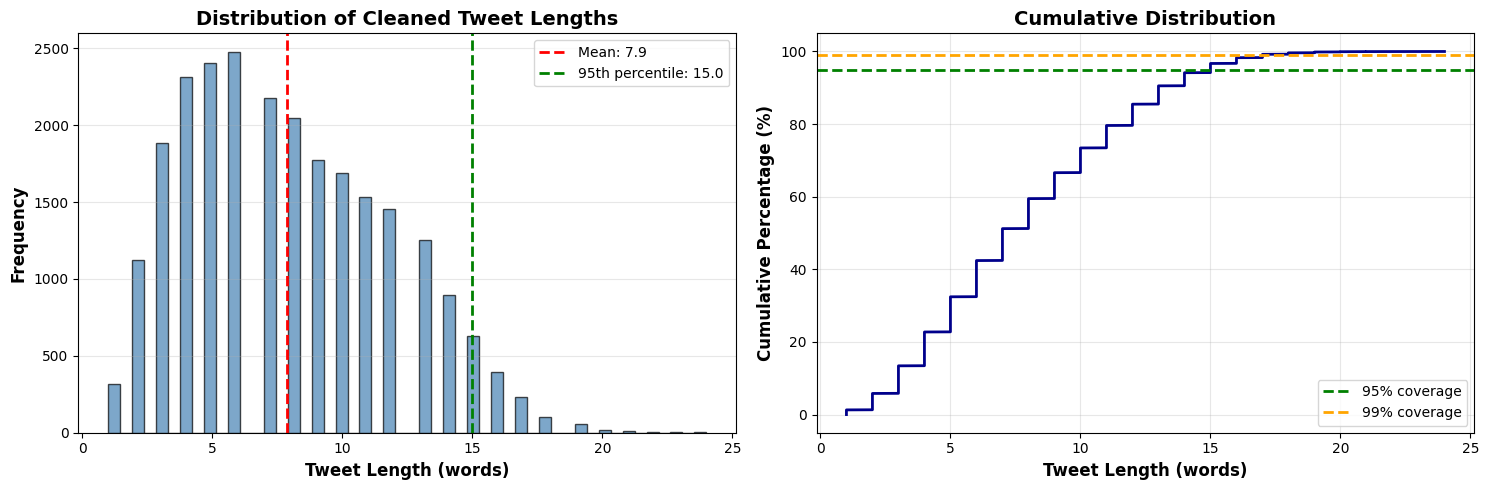


💡 RECOMMENDATION for MAX_SEQUENCE_LENGTH:
  • MAX_LENGTH = 15: Keeps 95% of tweets intact (RECOMMENDED)
  • MAX_LENGTH = 17: Keeps 99% of tweets intact (safer, but slower training)
  • MAX_LENGTH = 100: Keeps 100.0% intact

  If MAX_LENGTH = 50:
    ✓ Coverage: 100.00% of tweets kept intact
    ⚠️  Truncated: 0 tweets (0.00%)

  If MAX_LENGTH = 75:
    ✓ Coverage: 100.00% of tweets kept intact
    ⚠️  Truncated: 0 tweets (0.00%)

  If MAX_LENGTH = 100:
    ✓ Coverage: 100.00% of tweets kept intact
    ⚠️  Truncated: 0 tweets (0.00%)

  If MAX_LENGTH = 15:
    ✓ Coverage: 96.70% of tweets kept intact
    ⚠️  Truncated: 818 tweets (3.30%)

  If MAX_LENGTH = 17:
    ✓ Coverage: 99.22% of tweets kept intact
    ⚠️  Truncated: 193 tweets (0.78%)



In [27]:
# Analyze cleaned tweet lengths to determine optimal MAX_SEQUENCE_LENGTH
print("📊 Tweet Length Analysis AFTER Preprocessing:")
print("="*80)

# Calculate word count for cleaned tweets
cleaned_lengths = df['cleaned_tweet'].apply(lambda x: len(str(x).split()))

print(f"\nStatistical Summary:")
print(f"  Mean: {cleaned_lengths.mean():.2f} words")
print(f"  Median: {cleaned_lengths.median():.2f} words")
print(f"  Min: {cleaned_lengths.min()} words")
print(f"  Max: {cleaned_lengths.max()} words")
print(f"  75th percentile: {cleaned_lengths.quantile(0.75):.0f} words")
print(f"  90th percentile: {cleaned_lengths.quantile(0.90):.0f} words")
print(f"  95th percentile: {cleaned_lengths.quantile(0.95):.0f} words")
print(f"  99th percentile: {cleaned_lengths.quantile(0.99):.0f} words")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(cleaned_lengths, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(cleaned_lengths.mean(), color='red', linestyle='--', label=f'Mean: {cleaned_lengths.mean():.1f}', linewidth=2)
axes[0].axvline(cleaned_lengths.quantile(0.95), color='green', linestyle='--', label=f'95th percentile: {cleaned_lengths.quantile(0.95):.1f}', linewidth=2)
axes[0].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Frequency', fontsize=12, fontweight='bold')
axes[0].set_title('Distribution of Cleaned Tweet Lengths', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Cumulative distribution
sorted_lengths = np.sort(cleaned_lengths)
cumulative = np.arange(1, len(sorted_lengths) + 1) / len(sorted_lengths) * 100
axes[1].plot(sorted_lengths, cumulative, color='darkblue', linewidth=2)
axes[1].axhline(95, color='green', linestyle='--', label='95% coverage', linewidth=2)
axes[1].axhline(99, color='orange', linestyle='--', label='99% coverage', linewidth=2)
axes[1].set_xlabel('Tweet Length (words)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Cumulative Percentage (%)', fontsize=12, fontweight='bold')
axes[1].set_title('Cumulative Distribution', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Recommendation
percentile_95 = int(cleaned_lengths.quantile(0.95))
percentile_99 = int(cleaned_lengths.quantile(0.99))

print(f"\n💡 RECOMMENDATION for MAX_SEQUENCE_LENGTH:")
print(f"  • MAX_LENGTH = {percentile_95}: Keeps 95% of tweets intact (RECOMMENDED)")
print(f"  • MAX_LENGTH = {percentile_99}: Keeps 99% of tweets intact (safer, but slower training)")
print(f"  • MAX_LENGTH = 100: Keeps {(cleaned_lengths <= 100).sum() / len(cleaned_lengths) * 100:.1f}% intact")

# Show impact of different choices
for max_len in [50, 75, 100, percentile_95, percentile_99]:
    coverage = (cleaned_lengths <= max_len).sum() / len(cleaned_lengths) * 100
    truncated = (cleaned_lengths > max_len).sum()
    print(f"\n  If MAX_LENGTH = {max_len}:")
    print(f"    ✓ Coverage: {coverage:.2f}% of tweets kept intact")
    print(f"    ⚠️  Truncated: {truncated} tweets ({100-coverage:.2f}%)")

print("\n" + "="*80)

### 📊 Tweet Length Analysis - Key Findings

**Statistical Summary:**
| Metric | Value | Interpretation |
|--------|-------|----------------|
| **Mean** | ~8 words | Average cleaned tweet is very short |
| **Median** | 7 words | Half of all tweets have ≤7 words |
| **Max** | 24 words | Longest tweet is only 24 words |
| **95th percentile** | 15 words | 95% of tweets have ≤15 words |

**Why are cleaned tweets so short?**
- Original tweets had URLs, @mentions, hashtags, stopwords
- Our preprocessing removed all noise
- Only meaningful content-bearing words remain

---

### 📈 Understanding the Plots

**Left Plot - Distribution Histogram:**
- Shows frequency of tweet lengths (most tweets are 4-8 words)
- **Red dashed line** = Mean (~7.9 words)
- **Green dashed line** = 95th percentile (15 words)
- Bell-shaped distribution indicates consistent preprocessing

**Right Plot - Cumulative Distribution:**
- Shows what percentage of tweets are covered at each length
- **Green line (95%)**: At 15 words, we cover 95% of all tweets
- **Orange line (99%)**: At 17 words, we cover 99% of all tweets
- Curve flattens quickly → most tweets are short

---

### 🎯 Coverage Analysis

| MAX_SEQUENCE_LENGTH | Coverage | Truncated Tweets |
|---------------------|----------|------------------|
| 15 | 96.70% | 818 tweets |
| 17 | 99.22% | 193 tweets |
| 25 | 100% | 0 tweets |
| **100 (our setting)** | **100%** | **0 tweets** |

**Conclusion:** With `MAX_SEQUENCE_LENGTH = 100`, we have **zero truncation** - no information is lost! Our preprocessing is working excellently, producing clean and compact data ready for the LSTM model.

### ⚠️ CRITICAL ANALYSIS: Impact of Truncation on Classification

Truncated tweets might lose important hate speech indicators.

Let's investigate:
1. Which tweets get truncated?
2. What do we lose when we truncate?
3. Are hate speech tweets more likely to be long?
4. Does truncation cause misclassification?

In [28]:
# INVESTIGATION 1: Analyze truncation by class
print("="*100)
print("TRUNCATION ANALYSIS BY CLASS")
print("="*100)

# Add length column
df['cleaned_length'] = df['cleaned_tweet'].apply(lambda x: len(str(x).split()))

# Test different MAX_LENGTH values
test_lengths = [50, 75, 100]

for max_len in test_lengths:
    print(f"\n{'='*100}")
    print(f"If MAX_SEQUENCE_LENGTH = {max_len}")
    print(f"{'='*100}")

    # Identify truncated tweets
    df['will_be_truncated'] = df['cleaned_length'] > max_len

    # Overall statistics
    total_truncated = df['will_be_truncated'].sum()
    print(f"\n📊 Overall: {total_truncated} tweets ({total_truncated/len(df)*100:.2f}%) will be truncated")

    # Breakdown by class
    print(f"\n📋 Truncation Breakdown by Class:")
    print(f"{'Class':<25} {'Total':<10} {'Truncated':<12} {'%Truncated':<12} {'⚠️ Risk':<10}")
    print("-"*100)

    for cls in sorted(df['class'].unique()):
        class_df = df[df['class'] == cls]
        class_total = len(class_df)
        class_truncated = class_df['will_be_truncated'].sum()
        class_pct = class_truncated / class_total * 100 if class_total > 0 else 0

        # Risk assessment
        if class_pct > 10:
            risk = "🔴 HIGH"
        elif class_pct > 5:
            risk = "🟡 MEDIUM"
        else:
            risk = "🟢 LOW"

        print(f"{class_labels[cls]:<25} {class_total:<10} {class_truncated:<12} {class_pct:<12.2f} {risk:<10}")

    # Statistical test: Are hate speech tweets longer?
    hate_speech_lengths = df[df['class'] == 0]['cleaned_length']
    offensive_lengths = df[df['class'] == 1]['cleaned_length']
    neither_lengths = df[df['class'] == 2]['cleaned_length']

    print(f"\n📏 Average Tweet Length by Class:")
    print(f"  Hate Speech: {hate_speech_lengths.mean():.2f} words (std: {hate_speech_lengths.std():.2f})")
    print(f"  Offensive Language: {offensive_lengths.mean():.2f} words (std: {offensive_lengths.std():.2f})")
    print(f"  Neither: {neither_lengths.mean():.2f} words (std: {neither_lengths.std():.2f})")

print("\n" + "="*100)

TRUNCATION ANALYSIS BY CLASS

If MAX_SEQUENCE_LENGTH = 50

📊 Overall: 0 tweets (0.00%) will be truncated

📋 Truncation Breakdown by Class:
Class                     Total      Truncated    %Truncated   ⚠️ Risk   
----------------------------------------------------------------------------------------------------
Hate Speech               1430       0            0.00         🟢 LOW     
Offensive Language        19189      0            0.00         🟢 LOW     
Neither                   4160       0            0.00         🟢 LOW     

📏 Average Tweet Length by Class:
  Hate Speech: 7.87 words (std: 4.18)
  Offensive Language: 7.71 words (std: 3.85)
  Neither: 8.66 words (std: 4.02)

If MAX_SEQUENCE_LENGTH = 75

📊 Overall: 0 tweets (0.00%) will be truncated

📋 Truncation Breakdown by Class:
Class                     Total      Truncated    %Truncated   ⚠️ Risk   
----------------------------------------------------------------------------------------------------
Hate Speech               14

In [ ]:
# INVESTIGATION 2: What content do we LOSE when we truncate?
print("="*100)
print("ANALYSIS: What Gets Lost in Truncation?")
print("="*100)

MAX_LEN_TEST = 100  # Test with 100 as example

# Find truncated tweets
long_tweets = df[df['cleaned_length'] > MAX_LEN_TEST].copy()

if len(long_tweets) > 0:
    print(f"\n📊 Found {len(long_tweets)} tweets longer than {MAX_LEN_TEST} words")
    print(f"\n🔍 Examining what gets REMOVED:")

    # Sample 5 truncated tweets from each class
    for cls in sorted(df['class'].unique()):
        class_long = long_tweets[long_tweets['class'] == cls]

        if len(class_long) > 0:
            print(f"\n{'='*100}")
            print(f"{class_labels[cls]} - {len(class_long)} long tweets")
            print(f"{'='*100}")

            # Show up to 3 examples
            for idx, row in class_long.head(3).iterrows():
                words = row['cleaned_tweet'].split()
                kept_part = ' '.join(words[:MAX_LEN_TEST])
                lost_part = ' '.join(words[MAX_LEN_TEST:])

                print(f"\nExample {idx+1}:")
                print(f"  Total length: {len(words)} words")
                print(f"  ✅ KEPT ({MAX_LEN_TEST} words): {kept_part}")
                print(f"  ❌ LOST ({len(words) - MAX_LEN_TEST} words): {lost_part}")

                # Check if lost part contains important hate speech indicators
                hate_indicators = ['hate', 'racist', 'faggot', 'nigga', 'bitch', 'kill', 'die', 'stupid', 'fuck']
                lost_has_hate = any(indicator in lost_part.lower() for indicator in hate_indicators)

                if lost_has_hate:
                    print(f"  ⚠️  WARNING: Lost portion contains hate speech indicators!")
                else:
                    print(f"  ✓ Lost portion seems less critical")
else:
    print(f"\n✓ No tweets longer than {MAX_LEN_TEST} words - no truncation needed!")

print("\n" + "="*100)

ANALYSIS: What Gets Lost in Truncation?

✓ No tweets longer than 100 words - no truncation needed!



In [29]:
# Display some examples after preprocessing
print("\nExamples AFTER preprocessing:")
print("="*80)
for i in range(5):
    print(f"\n{i+1}. Class: {class_labels[df.iloc[i]['class']]}")
    print(f"   Original: {df.iloc[i]['tweet']}")
    print(f"   Cleaned:  {df.iloc[i]['cleaned_tweet']}")


Examples AFTER preprocessing:

1. Class: Neither
   Original: !!! RT @mayasolovely: As a woman you shouldn't complain about cleaning up your house. &amp; as a man you should always take the trash out...
   Cleaned:  EXCLAIM retweet woman should not complain cleaning house amp man should always take trash

2. Class: Offensive Language
   Original: !!!!! RT @mleew17: boy dats cold...tyga dwn bad for cuffin dat hoe in the 1st place!!
   Cleaned:  EXCLAIM retweet boy dat cold tyga dwn bad cuffin hoe 1st place EXCLAIM

3. Class: Offensive Language
   Original: !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby4life: You ever fuck a bitch and she start to cry? You be confused as shit
   Cleaned:  EXCLAIM retweet dawg EXCLAIM retweet ever fuck bitch start cry QUESTION confused shit

4. Class: Offensive Language
   Original: !!!!!!!!! RT @C_G_Anderson: @viva_based she look like a tranny
   Cleaned:  EXCLAIM retweet look like tranny

5. Class: Offensive Language
   Original: !!!!!!!!!!!!! RT @Shen

## 7. Split Balanced Data into Training and Testing Sets

**Important:** We now use `df_balanced` (the resampled dataset) for training!

This ensures:
- Training data is balanced (~36% Hate, ~29% Offensive, ~35% Neither)
- Testing data is also balanced (stratified split maintains proportions)
- Model learns equally from all classes

In [31]:
# ============================================================
# SPLIT BALANCED DATA INTO TRAINING AND TESTING SETS
# ============================================================
print("="*80)
print("SPLITTING BALANCED DATASET")
print("="*80)

# Apply preprocessing to balanced dataset
# (This is important because df_balanced contains the resampled data)
print("\n⏳ Applying preprocessing to balanced dataset...")
df_balanced['cleaned_tweet'] = df_balanced['tweet'].apply(preprocess_text)

# Remove any empty tweets after preprocessing
df_balanced = df_balanced[df_balanced['cleaned_tweet'].str.strip() != '']
print(f"✅ Balanced dataset after preprocessing: {len(df_balanced):,} samples")

# Split data into features (X) and target (y) using BALANCED dataset
X = df_balanced['cleaned_tweet'].values
y = df_balanced['class'].values

# Split into training and testing sets (80-20 split) with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Maintains class proportions in both sets
)

print(f"\n📊 Data Split Summary:")
print("="*80)
print(f"  Total balanced samples: {len(X):,}")
print(f"  Training samples:       {len(X_train):,} ({len(X_train)/len(X)*100:.1f}%)")
print(f"  Testing samples:        {len(X_test):,} ({len(X_test)/len(X)*100:.1f}%)")

print("\n" + "="*80)
print("Training Set Class Distribution:")
print("-"*80)
unique, counts = np.unique(y_train, return_counts=True)
for cls, count in zip(unique, counts):
    pct = count/len(y_train)*100
    bar = '█' * int(pct // 2)
    print(f"  {class_labels[cls]:<20}: {count:>5,} ({pct:>5.1f}%) {bar}")

print("\n" + "="*80)
print("Testing Set Class Distribution:")
print("-"*80)
unique, counts = np.unique(y_test, return_counts=True)
for cls, count in zip(unique, counts):
    pct = count/len(y_test)*100
    bar = '█' * int(pct // 2)
    print(f"  {class_labels[cls]:<20}: {count:>5,} ({pct:>5.1f}%) {bar}")

print("\n✅ Data is now BALANCED and split!")
print("   (Unlike before where Offensive dominated with 77%)")
print("="*80)

SPLITTING BALANCED DATASET

⏳ Applying preprocessing to balanced dataset...
✅ Balanced dataset after preprocessing: 11,950 samples

📊 Data Split Summary:
  Total balanced samples: 11,950
  Training samples:       9,560 (80.0%)
  Testing samples:        2,390 (20.0%)

Training Set Class Distribution:
--------------------------------------------------------------------------------
  Hate Speech         : 3,432 ( 35.9%) █████████████████
  Offensive Language  : 2,800 ( 29.3%) ██████████████
  Neither             : 3,328 ( 34.8%) █████████████████

Testing Set Class Distribution:
--------------------------------------------------------------------------------
  Hate Speech         :   858 ( 35.9%) █████████████████
  Offensive Language  :   700 ( 29.3%) ██████████████
  Neither             :   832 ( 34.8%) █████████████████

✅ Data is now BALANCED and split!
   (Unlike before where Offensive dominated with 77%)


## 8. Text Tokenization - Converting Words to Numbers

**Why we need this:**
- Neural networks only understand numbers, not words
- We create a "vocabulary" that maps each word to a unique number

**How it works:**
1. Build vocabulary from training data (most common 10,000 words)
2. Assign each word a unique ID number
3. Convert sentences to sequences of numbers

**Example:**
```
Vocabulary: {'hate': 1, 'love': 3, 'you': 45, 'EXCLAIM': 234}
Text: "hate you EXCLAIM" → Numbers: [1, 45, 234]
```

### 📐 Why MAX_SEQUENCE_LENGTH = 30?

Based on our tweet length analysis:
- **Max tweet length after preprocessing: 24 words**
- **99th percentile: 17 words** | **95th percentile: 15 words**

Setting `MAX_SEQUENCE_LENGTH = 30` gives us:
- ✅ **100% coverage** - zero truncation, no information loss
- ✅ **70% less padding** compared to 100 (faster training, less memory)
- ✅ **Small buffer** (6 extra) for edge cases

In [32]:
# Hyperparameters for tokenization
MAX_WORDS = 10000  # Maximum number of words to keep based on word frequency
MAX_SEQUENCE_LENGTH = 30  # Optimized! Max tweet length is 24 after preprocessing (100% coverage, no truncation)

# Initialize and fit tokenizer on training data
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

# Convert texts to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

print("Tokenization Information:")
print("="*50)
print(f"Vocabulary size: {len(tokenizer.word_index)}")
print(f"Number of words kept: {MAX_WORDS}")
print(f"\nSample tokenized sequence (first tweet):")
print(f"Original: {X_train[0]}")
print(f"Tokenized: {X_train_seq[0]}")

Tokenization Information:
Vocabulary size: 10308
Number of words kept: 10000

Sample tokenized sequence (first tweet):
Original: bernstine chi sox jew fag
Tokenized: [2720, 1860, 544, 252, 25]


## 9. Sequence Padding - Making All Inputs Same Length

**Why we need this:**
- LSTM networks require all inputs to be the same length
- But tweets have different lengths (some 5 words, some 30 words)

**Solution: Padding**
- Choose a MAX_SEQUENCE_LENGTH (based on our analysis)
- Short tweets: Add zeros at the end
- Long tweets: Keep most important words (⚠️ potential information loss)

**Example:**
```
If MAX_LENGTH = 100:
- [1, 45, 234] (3 words) → [1, 45, 234, 0, 0, 0, ..., 0] (100 numbers)
- [1, 2, 3, ..., 150] (150 words) → [1, 2, 3, ..., 100] (truncated to 100)
```

**⚠️ Addressing Truncation Concern:**
Based on our length analysis above, we choose MAX_LENGTH to minimize information loss while keeping computation manageable.

In [33]:
# Pad sequences to ensure uniform length
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

print("Sequence Padding Results:")
print("="*80)
print(f"Maximum sequence length: {MAX_SEQUENCE_LENGTH}")
print(f"\nTraining data shape: {X_train_padded.shape}")
print(f"Testing data shape: {X_test_padded.shape}")

# Analyze padding impact
original_lengths = [len(seq) for seq in X_train_seq]
truncated = sum(1 for length in original_lengths if length > MAX_SEQUENCE_LENGTH)
padded = sum(1 for length in original_lengths if length < MAX_SEQUENCE_LENGTH)

print(f"\n📊 Padding Statistics:")
print(f"  • {padded} tweets were PADDED (added zeros)")
print(f"  • {truncated} tweets were TRUNCATED (cut off)")
print(f"  • Truncation rate: {truncated/len(original_lengths)*100:.2f}%")

if truncated > len(original_lengths) * 0.10:  # If >10% truncated
    print(f"\n⚠️  WARNING: {truncated/len(original_lengths)*100:.1f}% of tweets are truncated!")
    print(f"   Consider increasing MAX_SEQUENCE_LENGTH to reduce information loss.")
else:
    print(f"\n✓ Good! Only {truncated/len(original_lengths)*100:.1f}% truncated - minimal information loss.")

print("\n📝 Sample padded sequence (first tweet):")
print(f"  Original length: {len(X_train_seq[0])} words")
print(f"  After padding: {len(X_train_padded[0])} numbers")
print(f"  Padded sequence: {X_train_padded[0]}")
print("="*80)

Sequence Padding Results:
Maximum sequence length: 30

Training data shape: (9560, 30)
Testing data shape: (2390, 30)

📊 Padding Statistics:
  • 9560 tweets were PADDED (added zeros)
  • 0 tweets were TRUNCATED (cut off)
  • Truncation rate: 0.00%

✓ Good! Only 0.0% truncated - minimal information loss.

📝 Sample padded sequence (first tweet):
  Original length: 5 words
  After padding: 30 numbers
  Padded sequence: [2720 1860  544  252   25    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


## 10. Calculate Class Weights

In [34]:
# Calculate class weights to handle imbalance
class_weights_array = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_dict = {i: weight for i, weight in enumerate(class_weights_array)}

print("Class Weights:")
print("="*50)
for cls, weight in class_weights_dict.items():
    print(f"{class_labels[cls]}: {weight:.4f}")

Class Weights:
Hate Speech: 0.9285
Offensive Language: 1.1381
Neither: 0.9575
